## Setup, Loading Data and CDFs

In [2]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'cwt-statement_1' #transform-group
CHANNEL = ''

In [3]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_1_cwt_1e5rawcomp_ravdess.ipynb


In [4]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/taiphan/Documents/GitHub/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawcomp/cwt/statement_1'

In [5]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [6]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [7]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [8]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


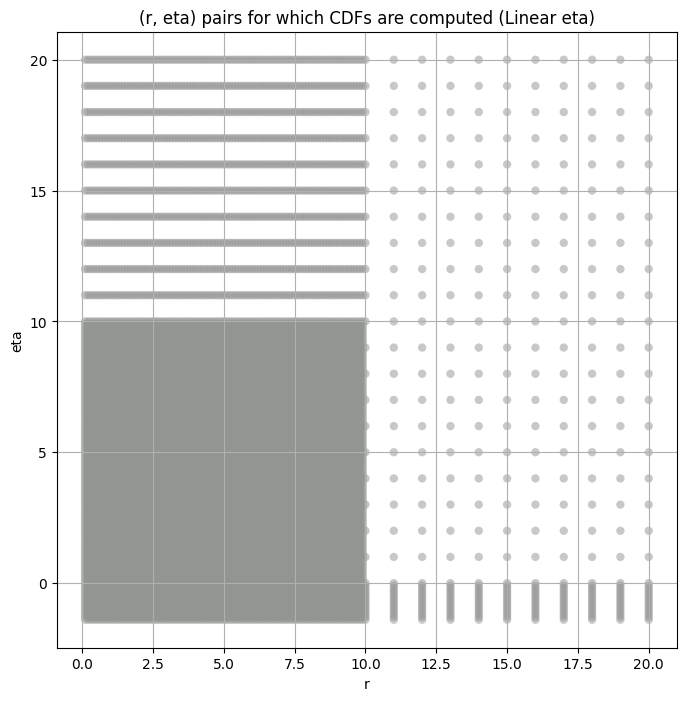

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336187e+08  8.402026e+08  1.032830e+09   13.948828   11.880425   
5     2.284851e+09  2.136287e+09  2.437953e+09    4.630411    4.061817   
8     1.703496e+09  1.595001e+09  1.815344e+09    4.384782    3.860582   
11    1.330439e+09  1.249094e+09  1.413363e+09    3.781705    3.406619   
14    3.536996e+08  3.235534e+08  3.850865e+08    9.487680    8.329473   
18    6.939949e+07  6.354010e+07  7.573060e+07    9.622860    7.358908   
21    2.943888e+07  2.653933e+07  3.262196e+07   13.824453   10.147264   
24    1.134324e+07  9.638629e+06  1.330031e+07   37.196182   26.251995   
27    4.075887e+06  3.260587e+06  5.040078e+06   69.577060   46.294106   
31    1.346257e+05  1.010121e+05  1.880231e+05  146.759080   58.790752   

      kurt_upper  total_samples  
band                             
2      16.469755     58035773.0  
5       5.246209     58035773.0  
8       4.929640     58035773.0  
11      4.176624     58035773.0  
14     10.714776     58035773.0  
18     12.719344     58035773.0  
21     19.833940     58035773.0  
24     51.220974     58035773.0  
27     98.474080     58035773.0  
31    427.171420     58035773.0

## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     9.336187e+08   9.336187e+08    9.020927e+08    8.784171e+08   
5     2.284851e+09   2.284851e+09    2.248634e+09    2.218806e+09   
8     1.703496e+09   1.703496e+09    1.678642e+09    1.656895e+09   
11    1.330439e+09   1.330439e+09    1.315438e+09    1.301947e+09   
14    3.536996e+08   3.536996e+08    3.451948e+08    3.380947e+08   
18    6.939949e+07   6.939949e+07    6.699136e+07    6.535210e+07   
21    2.943888e+07   2.943888e+07    2.813458e+07    2.728363e+07   
24    1.134324e+07   1.134324e+07    1.041036e+07    9.809005e+06   
27    4.075887e+06   4.075887e+06    3.570590e+06    3.264352e+06   
31    1.346257e+05   1.346257e+05    1.103397e+05    9.886002e+04   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       8.576955e+08     8.389375e+08     8.056109e+08     7.762925e+08   
5       2.191867e+09     2.166900e+09     2.121223e+09     2.079657e+09   
8       1.636974e+09     1.618440e+09     1.584464e+09     1.553571e+09   
11      1.289282e+09     1.277251e+09     1.254672e+09     1.233622e+09   
14      3.317276e+08     3.258744e+08     3.152841e+08     3.057949e+08   
18      6.398566e+07     6.278776e+07     6.072273e+07     5.895598e+07   
21      2.658452e+07     2.597913e+07     2.495252e+07     2.409062e+07   
24      9.333050e+06     8.934353e+06     8.286452e+06     7.769067e+06   
27      3.032414e+06     2.844505e+06     2.550588e+06     2.325856e+06   
31      9.055480e+04     8.404315e+04     7.421123e+04     6.695549e+04   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        7.498861e+08     7.257295e+08     7.033617e+08     6.444225e+08  
5        2.041149e+09     2.005108e+09     1.971119e+09     1.878879e+09  
8        1.525054e+09     1.498447e+09     1.473436e+09     1.405760e+09  
11       1.213775e+09     1.194914e+09     1.176894e+09     1.126917e+09  
14       2.971366e+08     2.891420e+08     2.816912e+08     2.618852e+08  
18       5.739813e+07     5.599767e+07     5.472105e+07     5.143779e+07  
21       2.334279e+07     2.267955e+07     2.208188e+07     2.055768e+07  
24       7.338579e+06     6.970768e+06     6.650480e+06     5.885228e+06  
27       2.145308e+06     1.995573e+06     1.868496e+06     1.577564e+06  
31       6.127981e+04     5.666280e+04     5.280059e+04     4.411963e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02149878772337125 9.336187e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.02239613663974179 9.020927e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.023087685561185962 8.784171e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.023709832717949207 8.576955e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.024285370725347977 8.3893754e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.023838078331196222 8.056109e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.024230246947298688 7.762925e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0251309259111445 7.498861e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.02598315726464228 7.2572954e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.026792695967080955 7.0336166e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.027306961496820402 6.444225e+08
Number of samples: 100000, Without approximation : 58035773.0


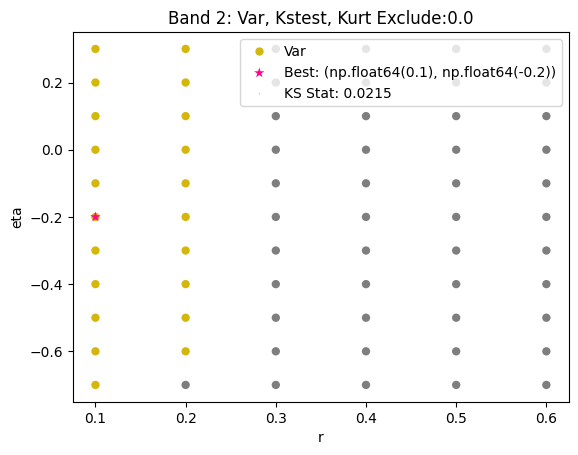

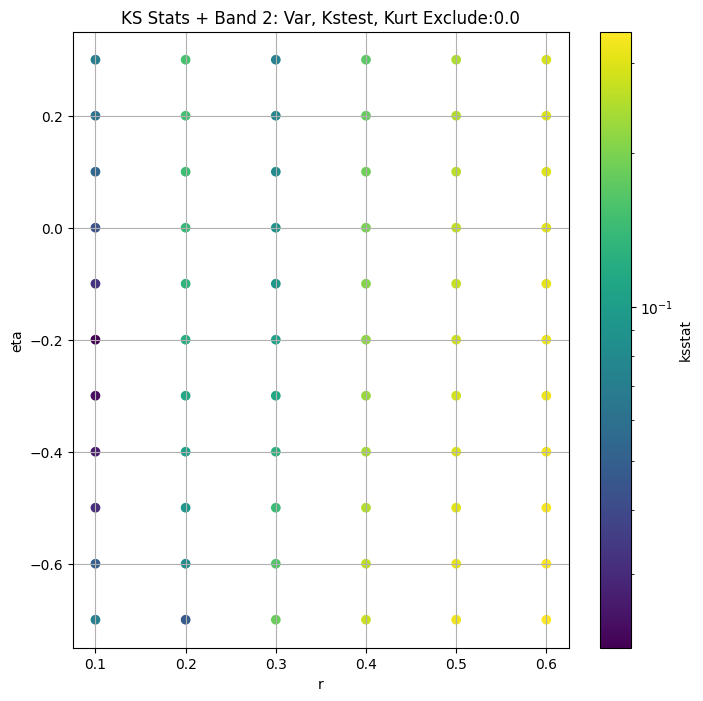

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.035041046831655376 2.284851e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03453875009548482 2.2486339e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.035313476220709 2.2188055e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03602112397295028 2.1918674e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03668310643672594 2.1668997e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0379135925663132 2.1212232e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03820274866790274 2.0796572e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.037591875925403195 2.0411488e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.037351705511004016 2.0051081e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.038344021105771356 1.9711195e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04035750528376747 1.8788794e+09
Number of samples: 100000, Without approximation : 58035773.0


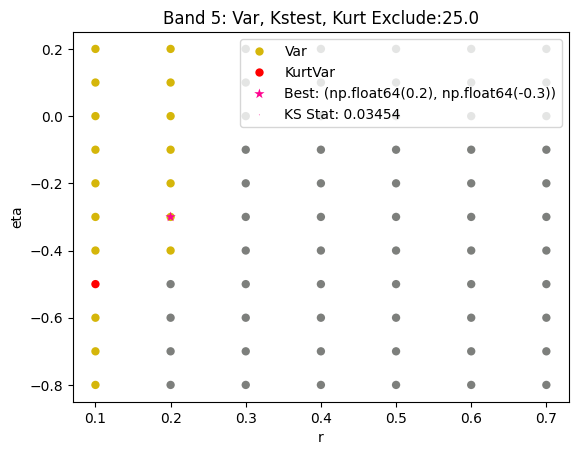

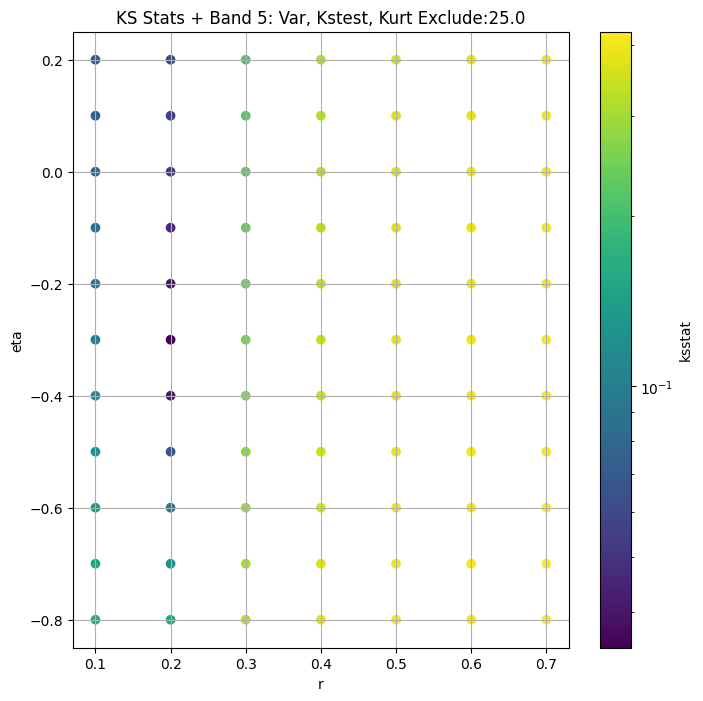

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023857272982346453 1.7034964e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.02485231283706875 1.6786418e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.024795405727219944 1.6568947e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024469462124661612 1.6369738e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.02431768135076516 1.6184398e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.025739319328591734 1.5844639e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.02601328109936696 1.5535708e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025703750882042756 1.5250545e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.02688695169685798 1.4984471e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.027284496824314997 1.4734362e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.028490301359645642 1.4057597e+09
Number of samples: 100000, Without approximation : 58035773.0


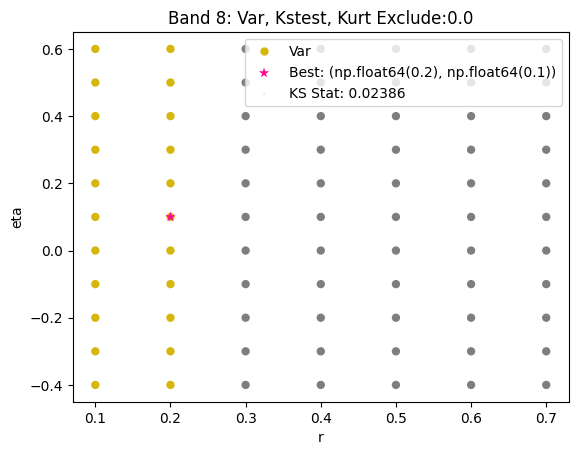

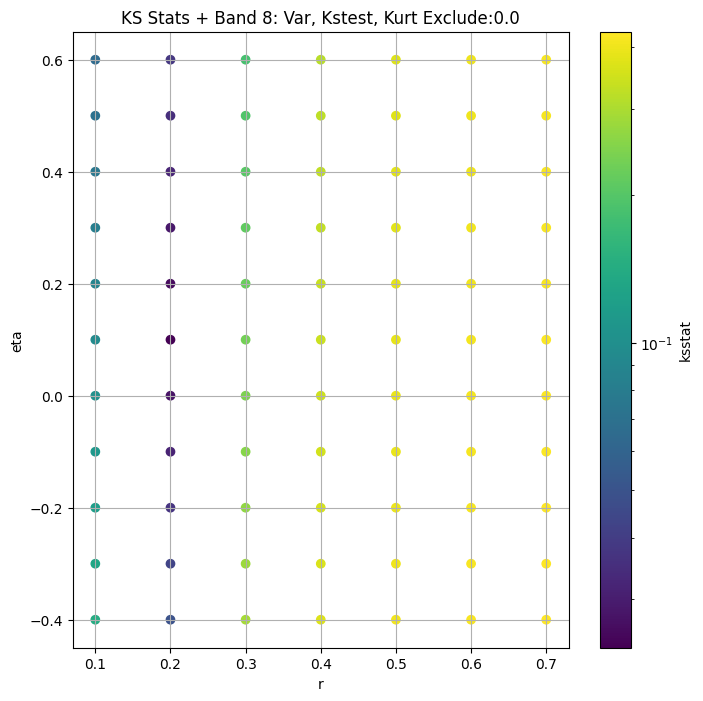

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.026377058383632315 1.3304392e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.027017285811058403 1.3154383e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.027598417557722923 1.3019468e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.028153194536407217 1.2892824e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.02868561957834445 1.2772512e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.029048898801238454 1.2546716e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.028435549437134278 1.233622e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.02899453619620808 1.2137751e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.029876376310894584 1.1949142e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.030734333601585506 1.1768938e+09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.03099166821893029 1.1269166e+09
Number of samples: 100000, Without approximation : 58035773.0


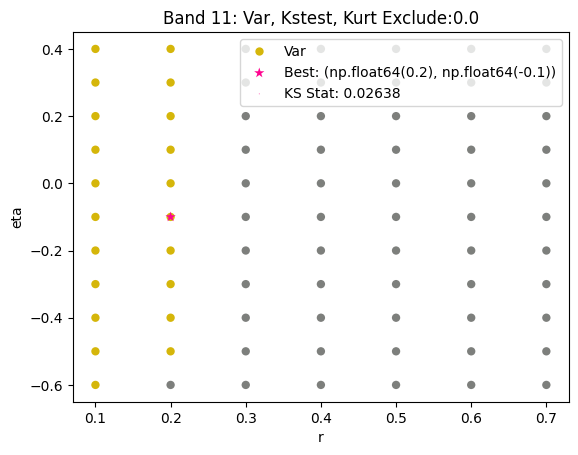

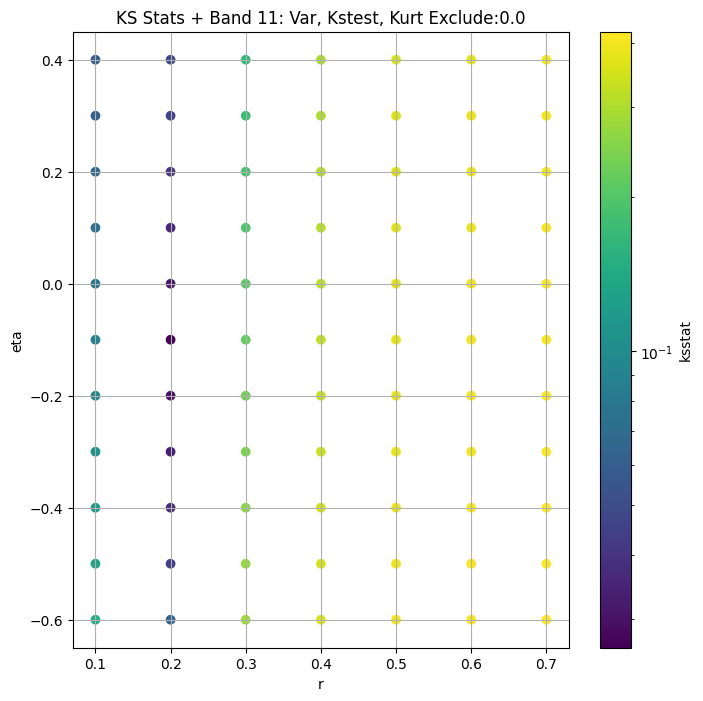

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.02042577545483537 3.5369962e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.021727449398240006 3.4519475e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.022217075174107648 3.380947e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02155716521044576 3.317276e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.020950946933612158 3.258744e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.020841592964692568 3.1528413e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.022464513585399692 3.0579494e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02399223282336893 2.9713664e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.025438074653553078 2.89142e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.02465411339183804 2.816912e+08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.026140852418680804 2.618852e+08
Number of samples: 100000, Without approximation : 58035773.0


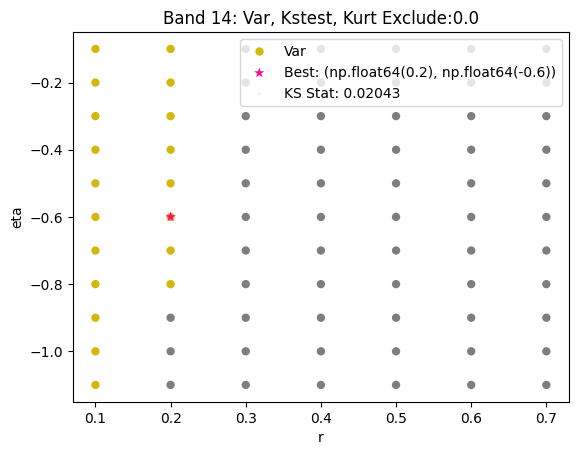

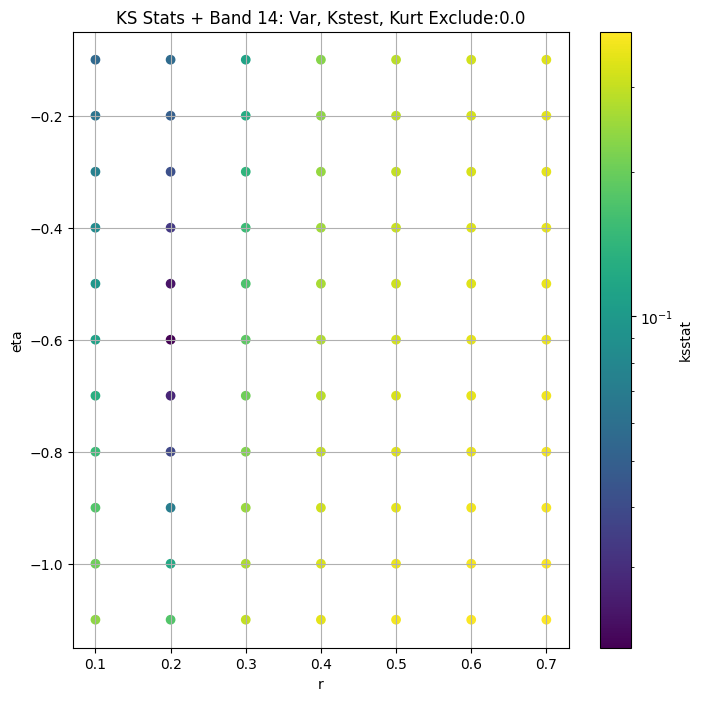

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.017086247652883024 6.939949e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.017403435824313918 6.6991364e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.01880852548285694 6.5352096e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.01963108999321439 6.398566e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.019093746247181187 6.2787764e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.01994747713635403 6.0722732e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.021601410599157433 5.8955984e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.020874887036221645 5.7398132e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.021974356163884545 5.5997668e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.023259659266446464 5.4721052e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.02457599930409815 5.1437788e+07
Number of samples: 100000, Without approximation : 58035773.0


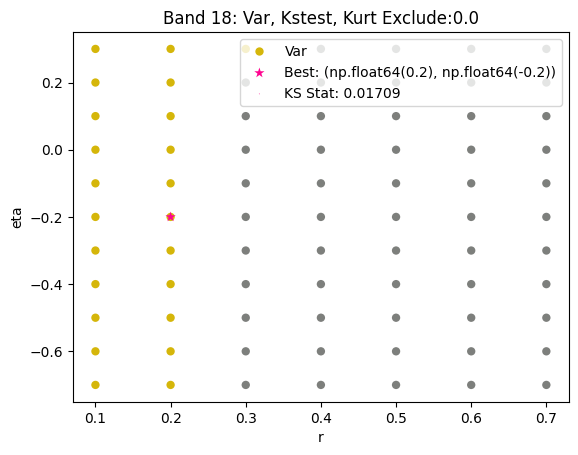

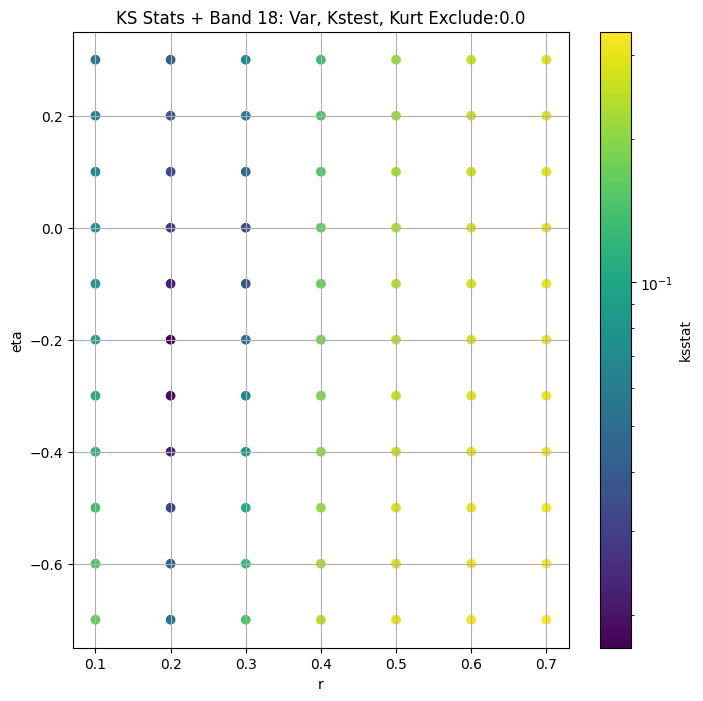

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.01789698875944702 2.9438876e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.017255623152837574 2.8134584e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.016624435752227565 2.7283628e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.017918766229892344 2.658452e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.0190762597961565 2.5979132e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.021123055479862096 2.4952518e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.020635614742178787 2.4090618e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.020476866632890153 2.3342792e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.02190008639904735 2.2679554e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.023235276342110714 2.2081876e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02360878321187518 2.0557684e+07
Number of samples: 100000, Without approximation : 58035773.0


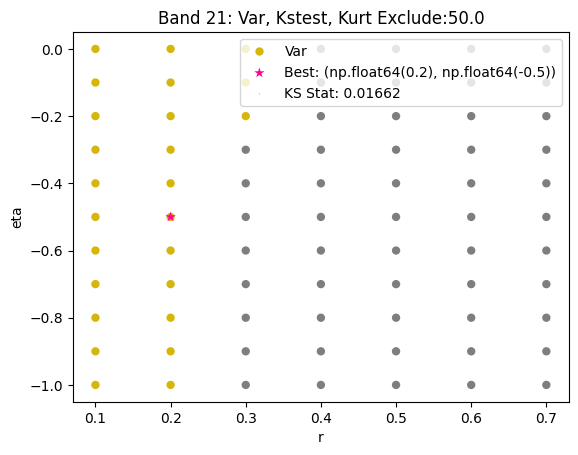

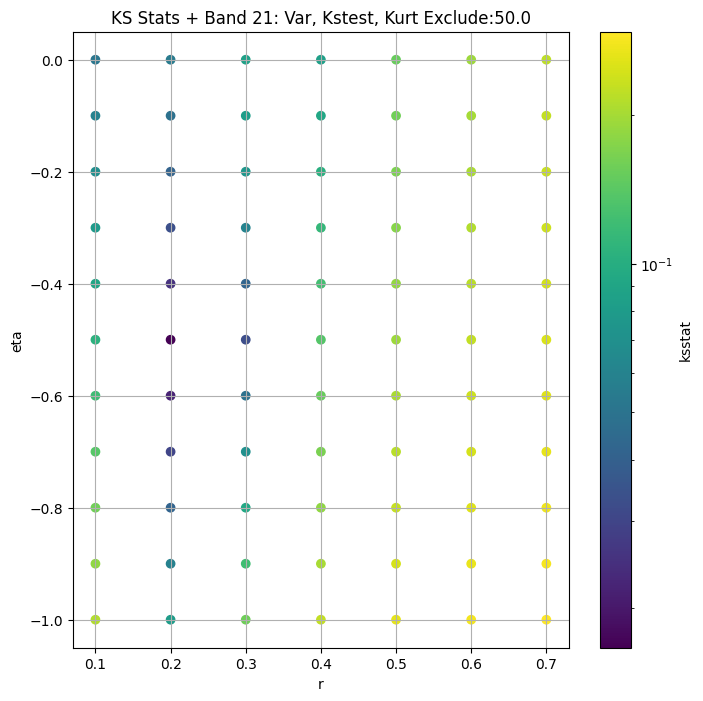

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.009177343451190811 1.134324e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.006724384393465649 1.0410364e+07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.009016780014976924 9.809005e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.01109657466021606 9.33305e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.012999189149213566 8.934353e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.015638436524845534 8.2864515e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.012775208947048089 7.769067e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.013914676981231208 7.338579e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.015903557449071418 6.9707675e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.01780432245752253 6.65048e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.017823032235468127 5.885228e+06
Number of samples: 100000, Without approximation : 58035773.0


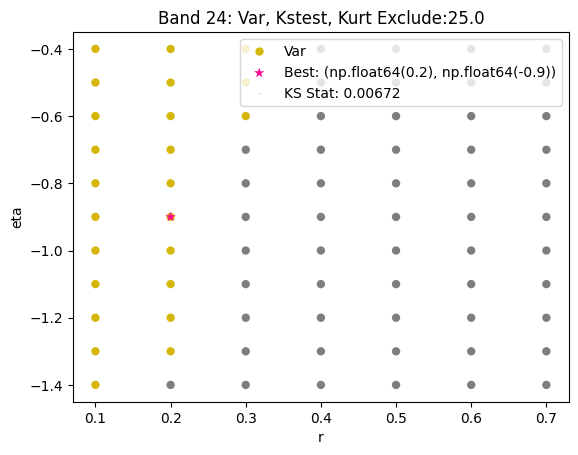

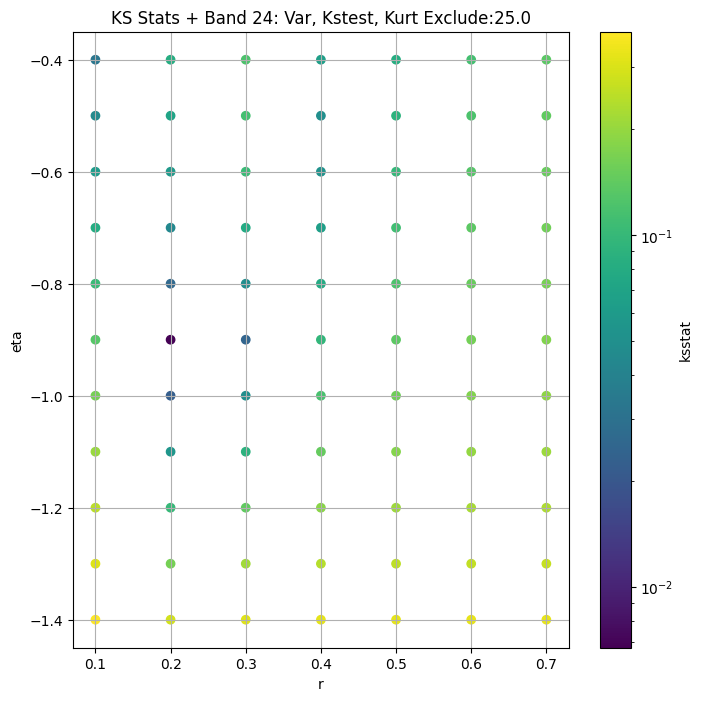

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.01229974616943108 4.075887e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.01229974616943108 3.5705898e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.01229974616943108 3.264352e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.01229974616943108 3.0324138e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.01229974616943108 2.8445052e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.01229974616943108 2.5505882e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.01229974616943108 2.3258558e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.01229974616943108 2.1453075e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.01229974616943108 1.9955729e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.01229974616943108 1.8684958e+06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.012244595895975263 1.5775644e+06
Number of samples: 100000, Without approximation : 58035773.0


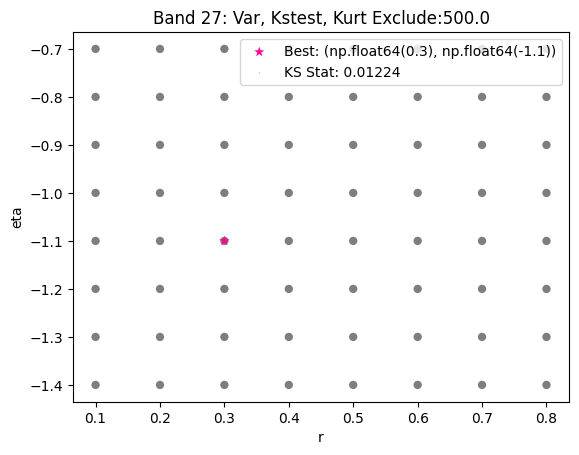

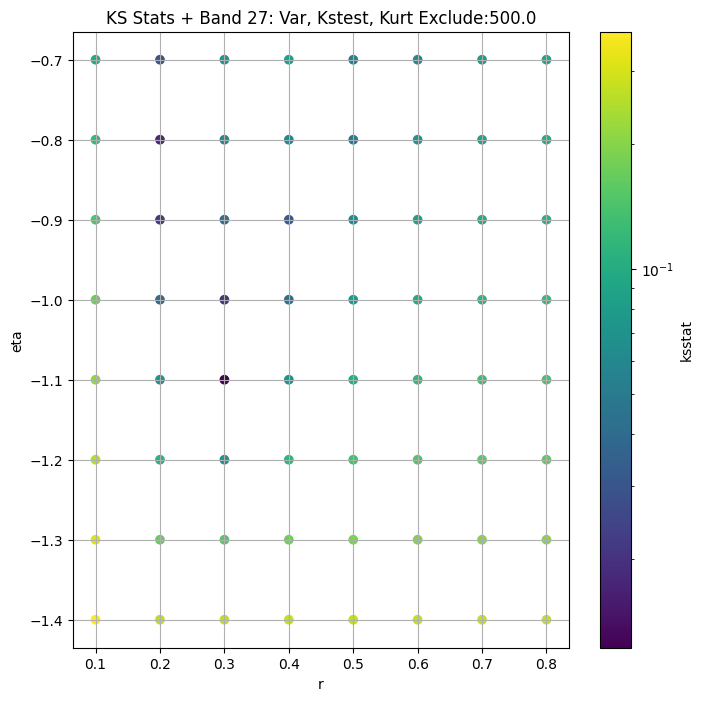

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.03421385978982944 134625.73


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03416857934684836 110339.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.033837410465126616 98860.016


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03356268423100672 90554.805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.033320893972355214 84043.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03509266253513865 74211.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03585388096504721 66955.49


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03565903881267318 61279.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.03547973209542232 56662.805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.035312312388394884 52800.586


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.03486028685222803 44119.633
Number of samples: 100000, Without approximation : 58035773.0


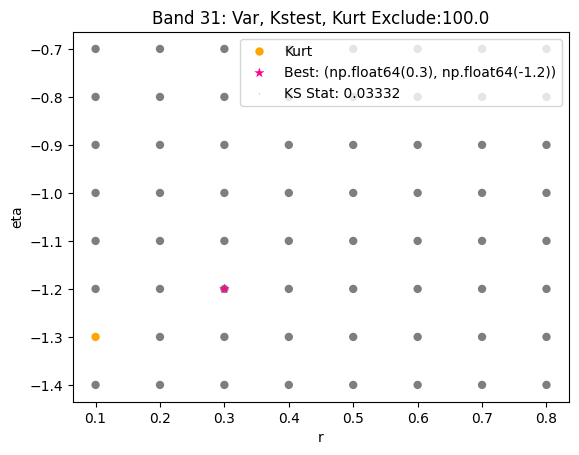

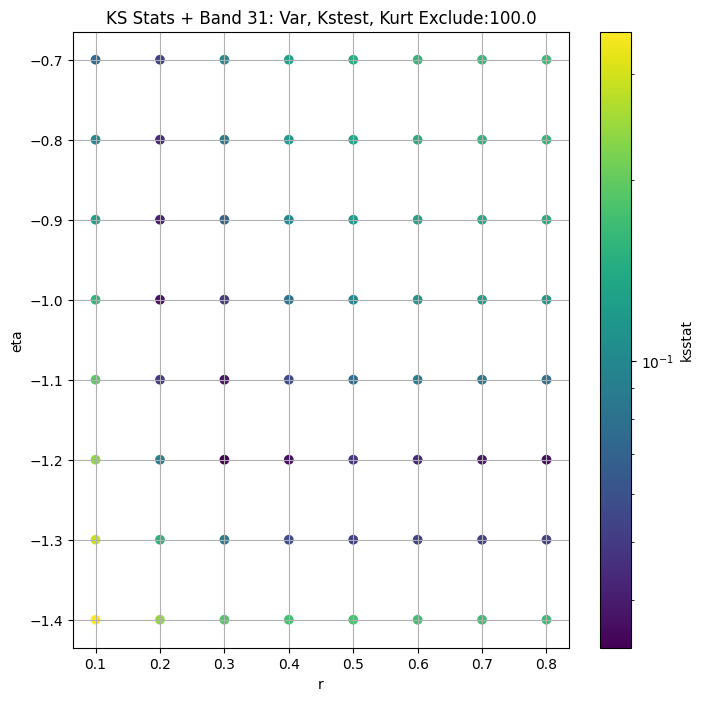

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336187e+08  8.402026e+08  1.032830e+09   13.948828   11.880425   
5     2.284851e+09  2.136287e+09  2.437953e+09    4.630411    4.061817   
8     1.703496e+09  1.595001e+09  1.815344e+09    4.384782    3.860582   
11    1.330439e+09  1.249094e+09  1.413363e+09    3.781705    3.406619   
14    3.536996e+08  3.235534e+08  3.850865e+08    9.487680    8.329473   
18    6.939949e+07  6.354010e+07  7.573060e+07    9.622860    7.358908   
21    2.943888e+07  2.653933e+07  3.262196e+07   13.824453   10.147264   
24    1.134324e+07  9.638629e+06  1.330031e+07   37.196182   26.251995   
27    4.075887e+06  3.260587e+06  5.040078e+06   69.577060   46.294106   
31    1.346257e+05  1.010121e+05  1.880231e+05  146.759080   58.790752   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.469755     58035773.0             0.021499        0.1         -0.2   
5       5.246209     58035773.0             0.034539        0.2         -0.3   
8       4.929640     58035773.0             0.023857        0.2          0.1   
11      4.176624     58035773.0             0.026377        0.2         -0.1   
14     10.714776     58035773.0             0.020426        0.2         -0.6   
18     12.719344     58035773.0             0.017086        0.2         -0.2   
21     19.833940     58035773.0             0.016624        0.2         -0.5   
24     51.220974     58035773.0             0.006724        0.2         -0.9   
27     98.474080     58035773.0             0.012245        0.3         -1.1   
31    427.171420     58035773.0             0.033321        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000398                     0.0        9.336187e+08   
5      74359.585185                    25.0        2.248634e+09   
8      17923.994613                     0.0        1.703496e+09   
11     23997.820491                     0.0        1.330439e+09   
14     34487.827634                     0.0        3.536996e+08   
18      1678.996599                     0.0        6.939949e+07   
21      1804.472751                    50.0        2.728363e+07   
24      4131.096825                    25.0        1.041036e+07   
27     95757.861788                   500.0        1.577564e+06   
31      9075.416219                   100.0        8.404315e+04   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000178  
5                    0.000178  
8                    0.000178  
11                   0.000178  
14                   0.000178  
18                   0.000178  
21                   0.000178  
24                   0.000178  
27                   0.000178  
31                   0.000178

In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [15]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.021531264954706635, var: 838937536.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.02095644490640757, var: 857695488.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.020736515468280856, var: 878417088.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.020043948799246092, var: 902092672.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.019959126966201834, var: 933618688.0
Number of samples: 100000, Without approximation : 58035773.0


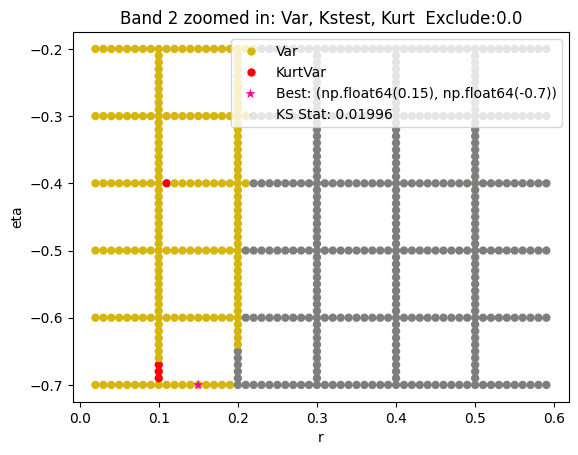

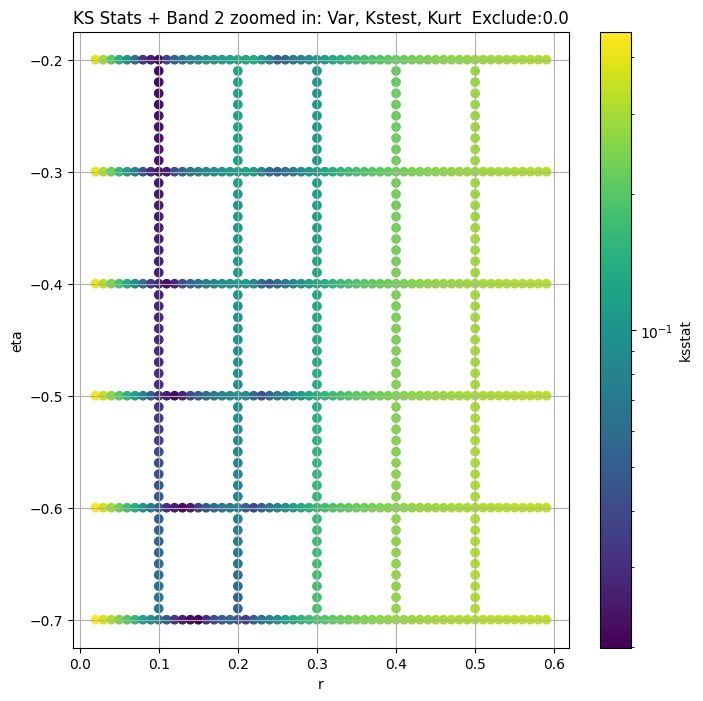

Band 5


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.03569964101248484, var: 2143451392.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.035461660930856384, var: 2166899712.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.03519800745027854, var: 2191867392.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.03489787301818466, var: 2218805504.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.03453875009548482, var: 2248633856.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.0343787593475014, var: 2284850944.0
Number of samples: 100000, Without approximation : 58035773.0


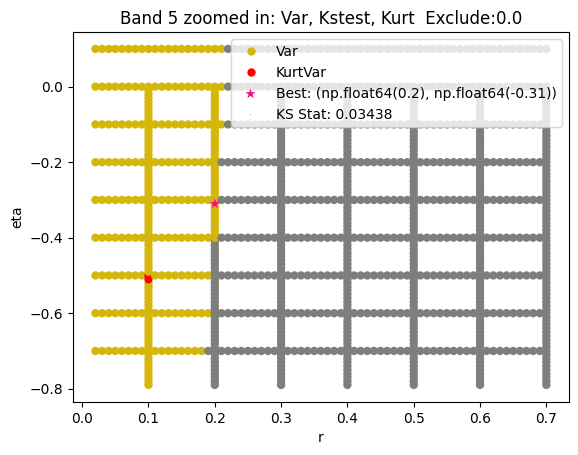

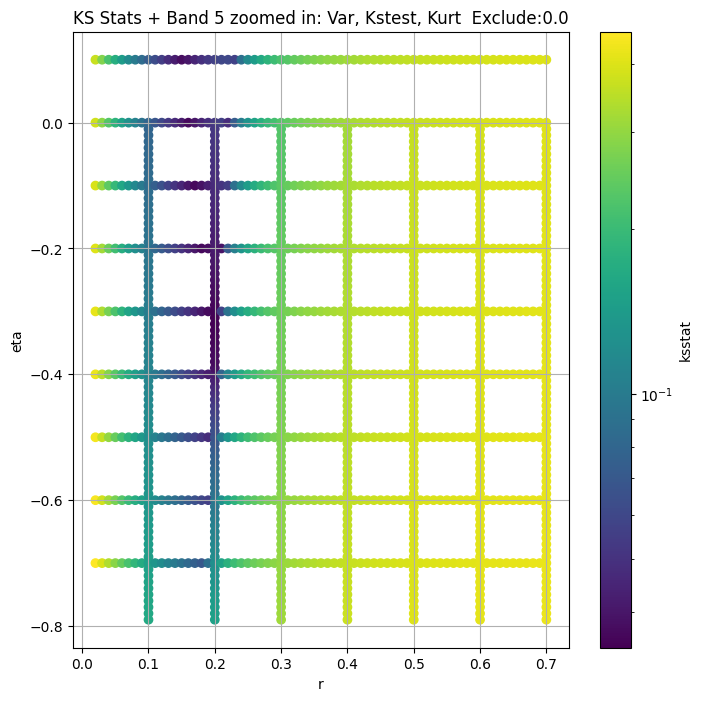

Band 8


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.02431768135076516, var: 1618439808.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.023767469350273185, var: 1636973824.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.02322513637082442, var: 1656894720.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.02327321577562491, var: 1678641792.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.02327321577562491, var: 1703496448.0
Number of samples: 100000, Without approximation : 58035773.0


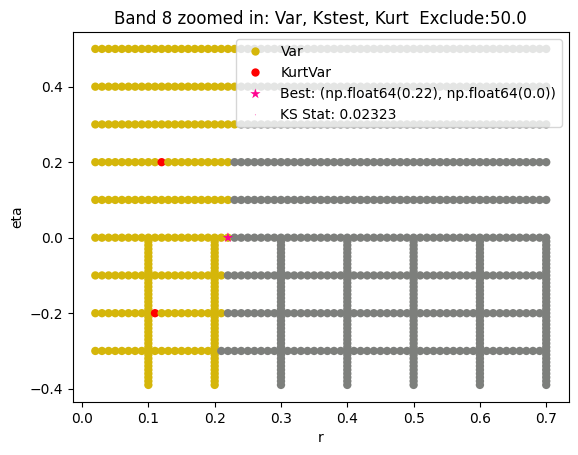

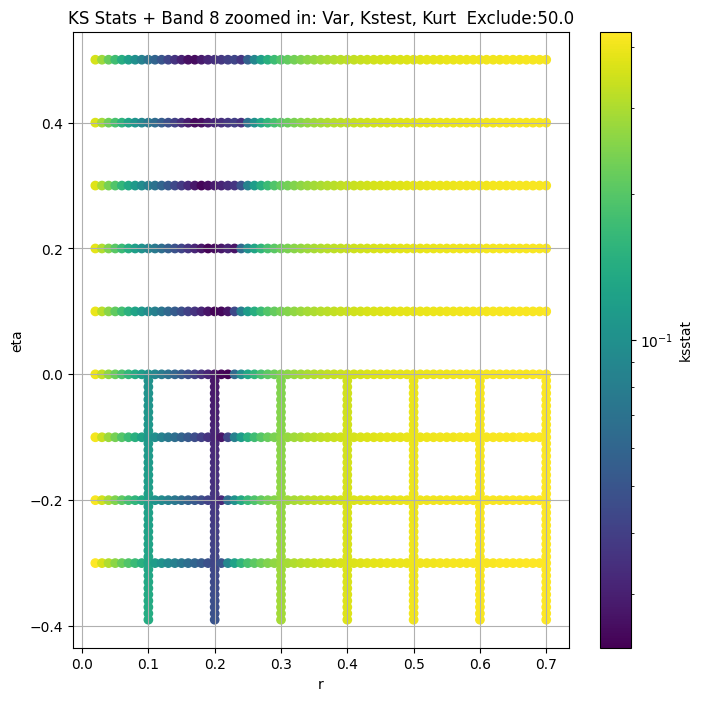

Band 11


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.027349112376828744, var: 1277251200.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.027077813055255584, var: 1289282432.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.02682958704539251, var: 1301946752.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.026667643512662487, var: 1315438336.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.026377058383632315, var: 1330439168.0
Number of samples: 100000, Without approximation : 58035773.0


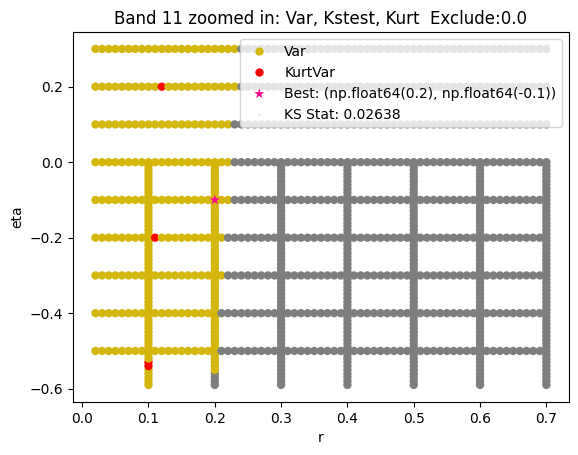

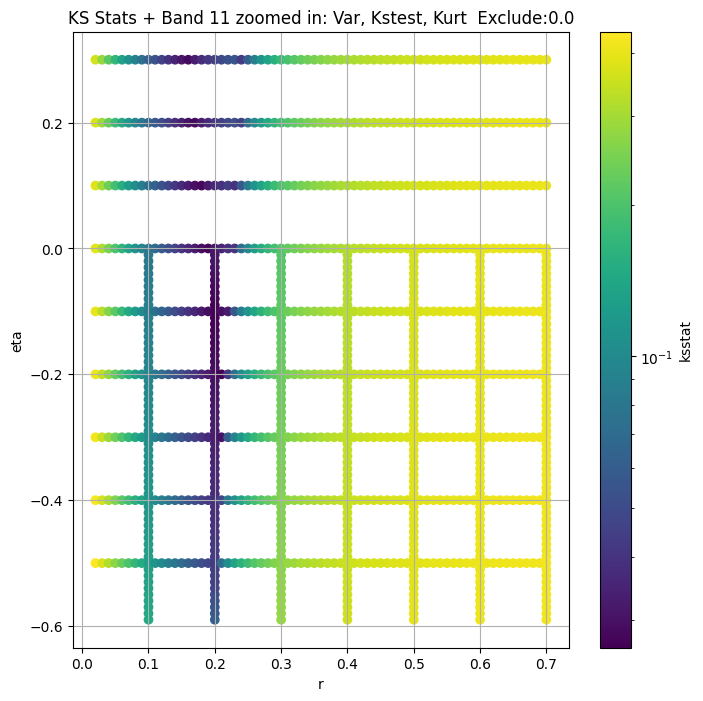

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.020018357941530895, var: 325874400.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.01966377320268281, var: 331727616.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.0192485212822886, var: 338094688.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.018186294103385348, var: 345194752.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.017985594248498882, var: 353699616.0
Number of samples: 100000, Without approximation : 58035773.0


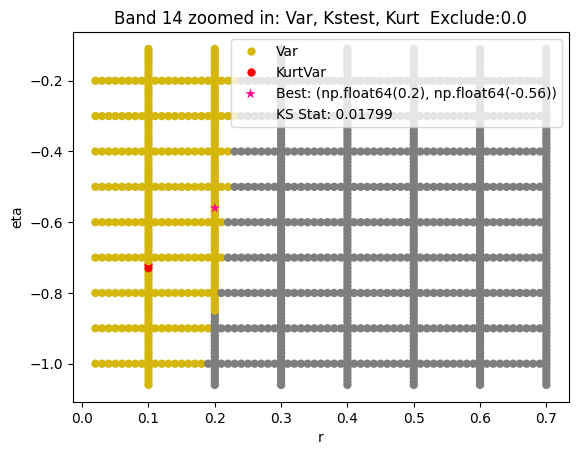

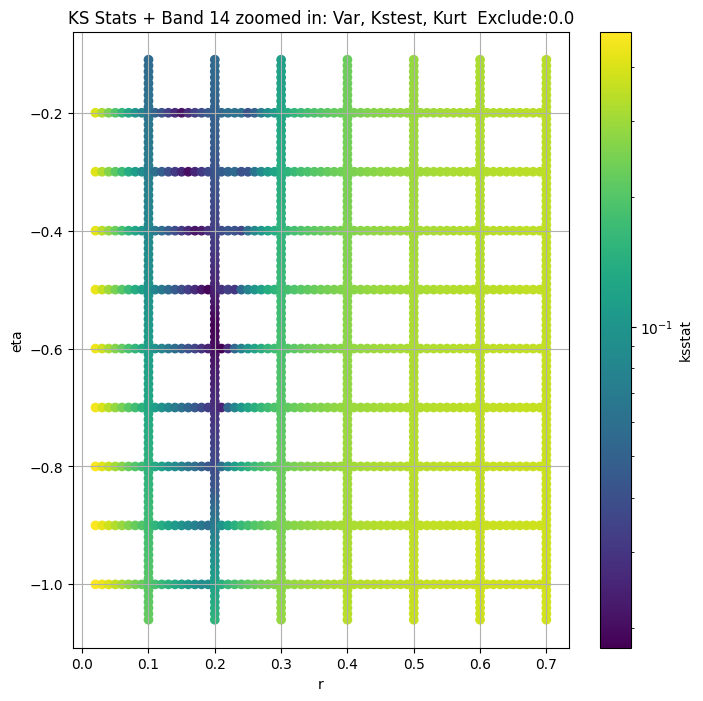

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.01714347423264484, var: 62787764.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01731806254706736, var: 63985660.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.016138290314413384, var: 65352096.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.01642003267183223, var: 66991364.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.014432490066044301, var: 69399488.0
Number of samples: 100000, Without approximation : 58035773.0


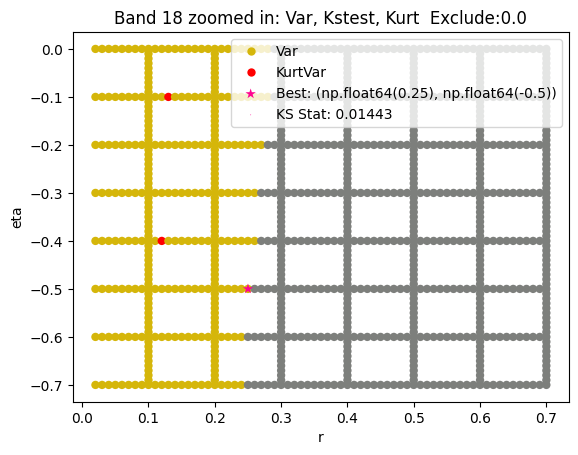

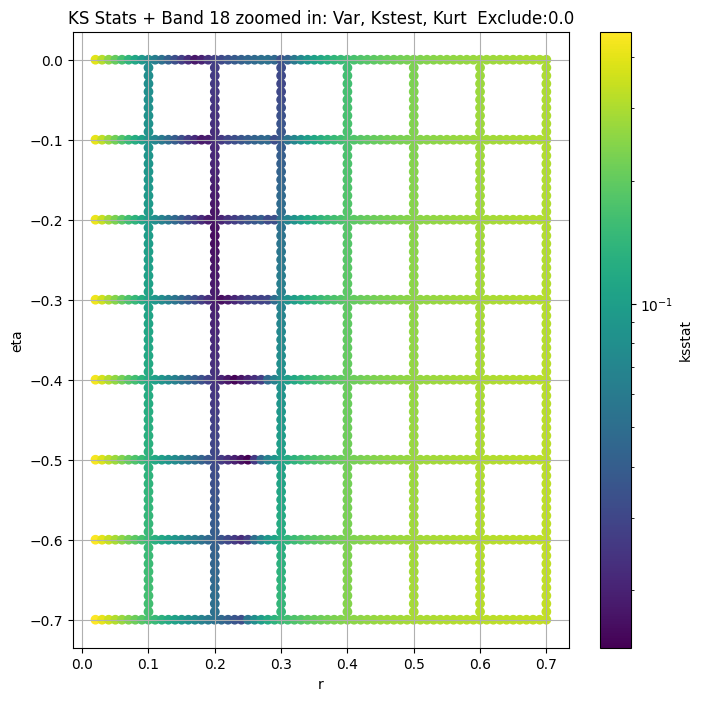

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 100 = 150, ksstat: 0.016041565725746887, var: 24952518.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 75 = 125, ksstat: 0.01638276750751011, var: 25440516.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 50 = 100, ksstat: 0.015954398955261143, var: 25979132.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 25 = 75, ksstat: 0.014848880425529343, var: 26584520.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 0 = 50, ksstat: 0.015377941917132154, var: 27283628.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + -25 = 25, ksstat: 0.014220468902927094, var: 28134584.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + -50 = 0, ksstat: 0.014317868308066473, var: 29438876.0
Number of samples: 100000, Without approximation : 58035773.0


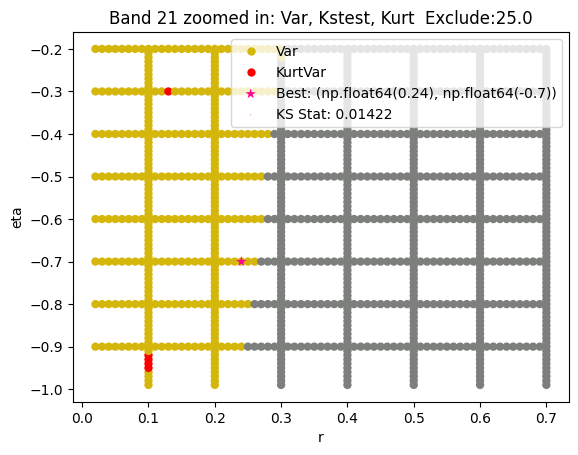

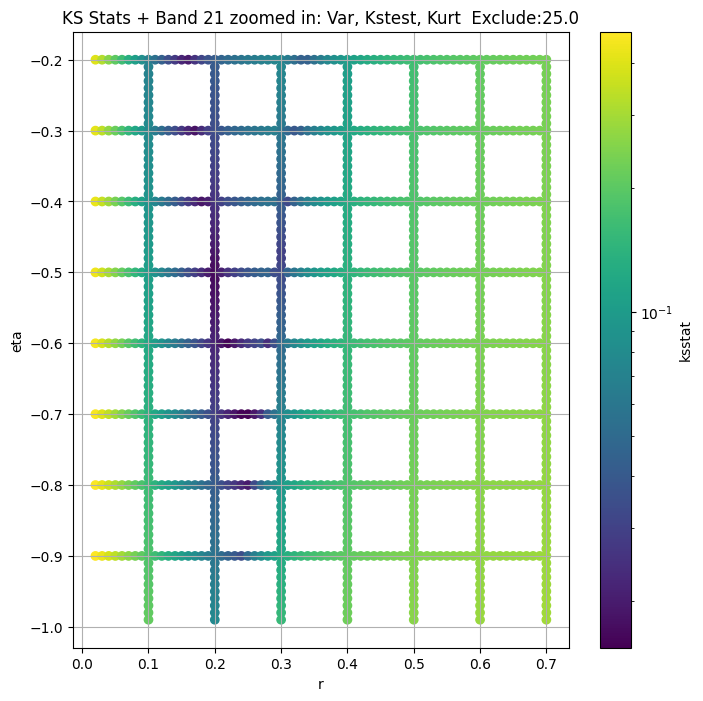

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 100 = 125, ksstat: 0.007971723116487972, var: 8590013.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 75 = 100, ksstat: 0.007089225460057809, var: 8934353.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 50 = 75, ksstat: 0.007409750719152411, var: 9333050.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 25 = 50, ksstat: 0.005729635039974257, var: 9809005.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 0 = 25, ksstat: 0.005757756343215403, var: 10410364.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + -25 = 0, ksstat: 0.0049463222828546455, var: 11343240.0
Number of samples: 100000, Without approximation : 58035773.0


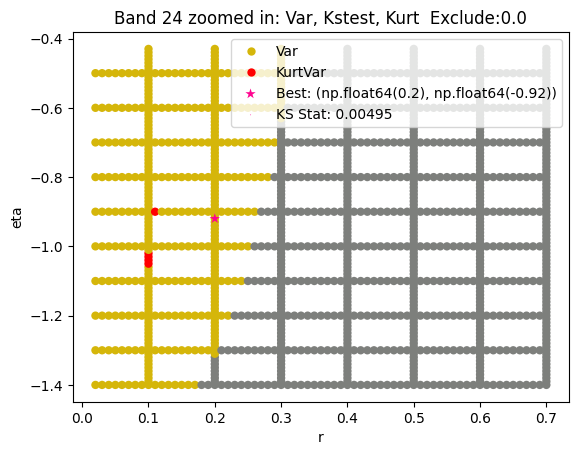

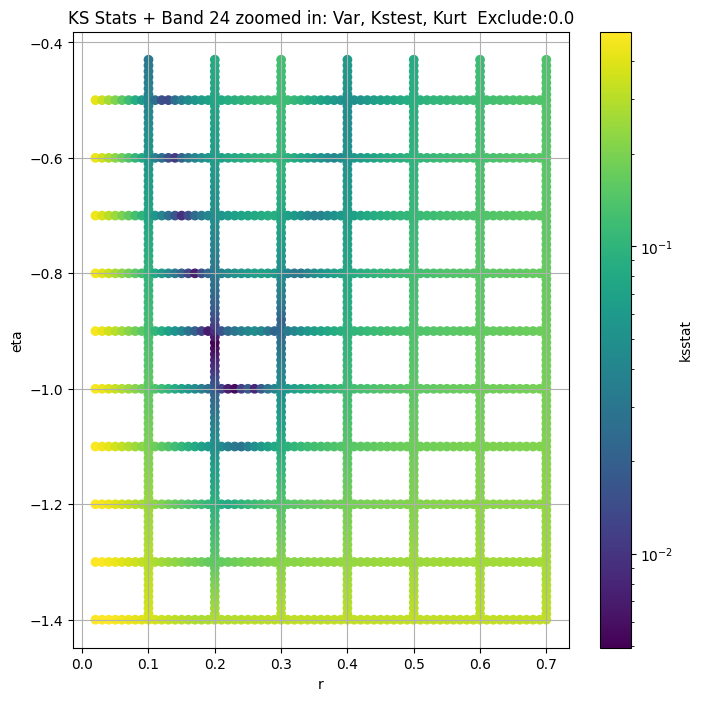

Band 27


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 100 = 600, ksstat: 0.012849018033816995, var: 1432894.875


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 75 = 575, ksstat: 0.012628510618966193, var: 1466356.875


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 50 = 550, ksstat: 0.012412592781477216, var: 1501512.875


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 25 = 525, ksstat: 0.012446470538789889, var: 1538514.75


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 0 = 500, ksstat: 0.012244595895975263, var: 1577564.375


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -25 = 475, ksstat: 0.0122768798267201, var: 1618867.375


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -50 = 450, ksstat: 0.011901424383382597, var: 1662653.625


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -75 = 425, ksstat: 0.011617855737545146, var: 1709175.625


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -100 = 400, ksstat: 0.011649883228661118, var: 1758737.875
Number of samples: 100000, Without approximation : 58035773.0


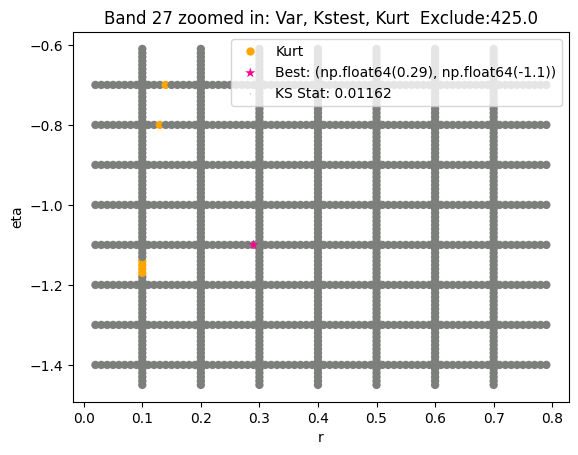

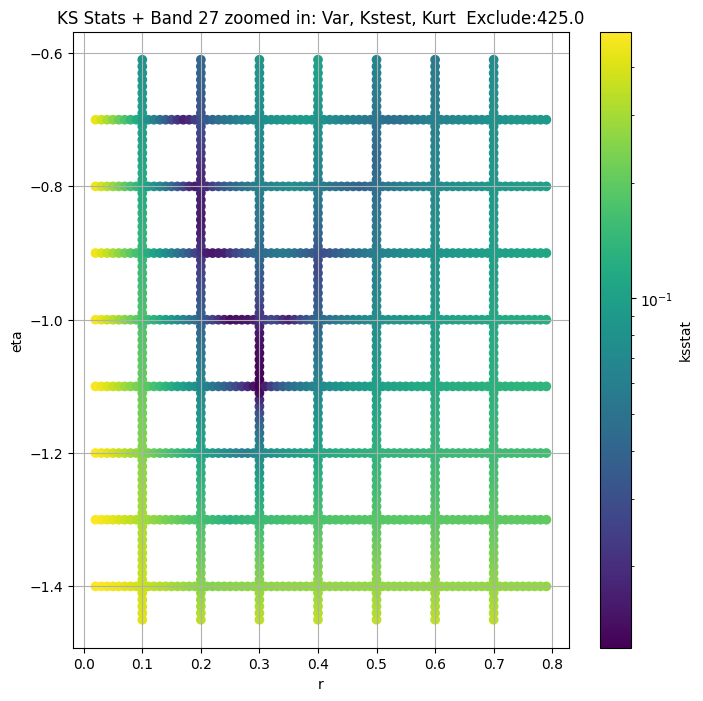

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 100 = 200, ksstat: 0.02642526205136253, var: 66955.4921875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 75 = 175, ksstat: 0.026334898201123336, var: 70340.578125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 50 = 150, ksstat: 0.026334898201123336, var: 74211.2265625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 25 = 125, ksstat: 0.026334898201123336, var: 78706.578125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 0 = 100, ksstat: 0.026334898201123336, var: 84043.1484375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -25 = 75, ksstat: 0.026334898201123336, var: 90554.8046875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -50 = 50, ksstat: 0.026334898201123336, var: 98860.015625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -75 = 25, ksstat: 0.026334898201123336, var: 110339.7421875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -100 = 0, ksstat: 0.026334898201123336, var: 134625.734375
Number of samples: 100000, Without approximation : 58035773.0


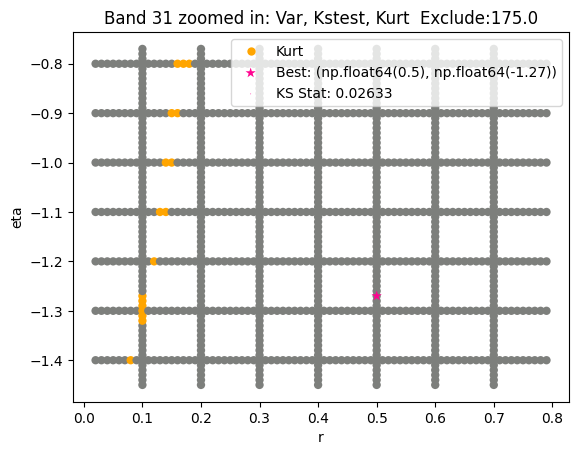

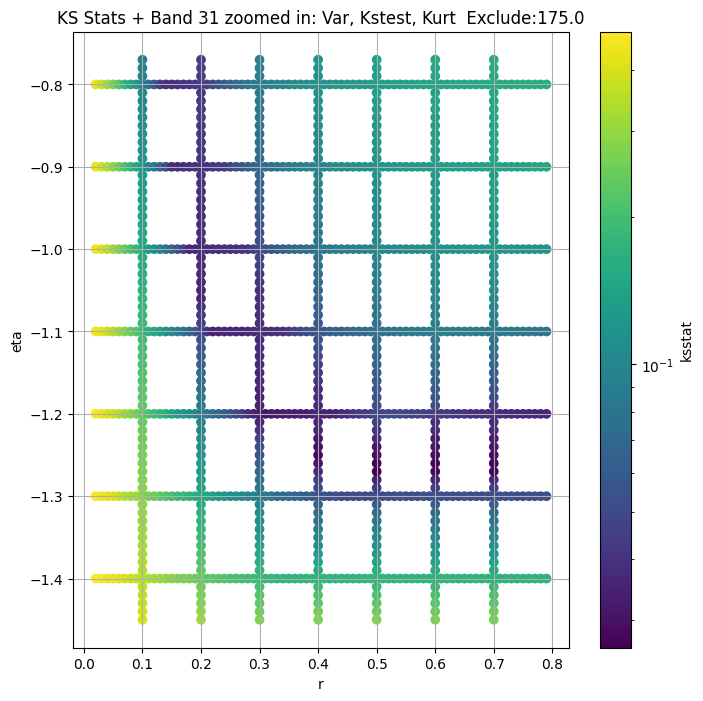

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336187e+08  8.402026e+08  1.032830e+09   13.948828   11.880425   
5     2.284851e+09  2.136287e+09  2.437953e+09    4.630411    4.061817   
8     1.703496e+09  1.595001e+09  1.815344e+09    4.384782    3.860582   
11    1.330439e+09  1.249094e+09  1.413363e+09    3.781705    3.406619   
14    3.536996e+08  3.235534e+08  3.850865e+08    9.487680    8.329473   
18    6.939949e+07  6.354010e+07  7.573060e+07    9.622860    7.358908   
21    2.943888e+07  2.653933e+07  3.262196e+07   13.824453   10.147264   
24    1.134324e+07  9.638629e+06  1.330031e+07   37.196182   26.251995   
27    4.075887e+06  3.260587e+06  5.040078e+06   69.577060   46.294106   
31    1.346257e+05  1.010121e+05  1.880231e+05  146.759080   58.790752   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.469755     58035773.0             0.021499        0.1         -0.2   
5       5.246209     58035773.0             0.034539        0.2         -0.3   
8       4.929640     58035773.0             0.023857        0.2          0.1   
11      4.176624     58035773.0             0.026377        0.2         -0.1   
14     10.714776     58035773.0             0.020426        0.2         -0.6   
18     12.719344     58035773.0             0.017086        0.2         -0.2   
21     19.833940     58035773.0             0.016624        0.2         -0.5   
24     51.220974     58035773.0             0.006724        0.2         -0.9   
27     98.474080     58035773.0             0.012245        0.3         -1.1   
31    427.171420     58035773.0             0.033321        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000398                     0.0        9.336187e+08   
5      74359.585185                    25.0        2.284851e+09   
8      17923.994613                     0.0        1.656895e+09   
11     23997.820491                     0.0        1.330439e+09   
14     34487.827634                     0.0        3.536996e+08   
18      1678.996599                     0.0        6.939949e+07   
21      1804.472751                    50.0        2.813458e+07   
24      4131.096825                    25.0        1.134324e+07   
27     95757.861788                   500.0        1.709176e+06   
31      9075.416219                   100.0        7.034058e+04   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000178          0.019959    0.15     -0.70   
5                    0.000178          0.034379    0.20     -0.31   
8                    0.000178          0.023225    0.22      0.00   
11                   0.000178          0.026377    0.20     -0.10   
14                   0.000178          0.017986    0.20     -0.56   
18                   0.000178          0.014432    0.25     -0.50   
21                   0.000178          0.014220    0.24     -0.70   
24                   0.000178          0.004946    0.20     -0.92   
27                   0.000178          0.011618    0.29     -1.10   
31                   0.000178          0.026335    0.50     -1.27   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2        938.580825                  0.0         4482  
5      78044.599874                  0.0         1492  
8      99081.876640                 50.0         3542  
11     23997.820491                  0.0         2656  
14     29415.558206                  0.0         5976  
18     82618.438095                  0.0         8964  
21     41770.021793                 25.0         8964  
24      5027.792359    

In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

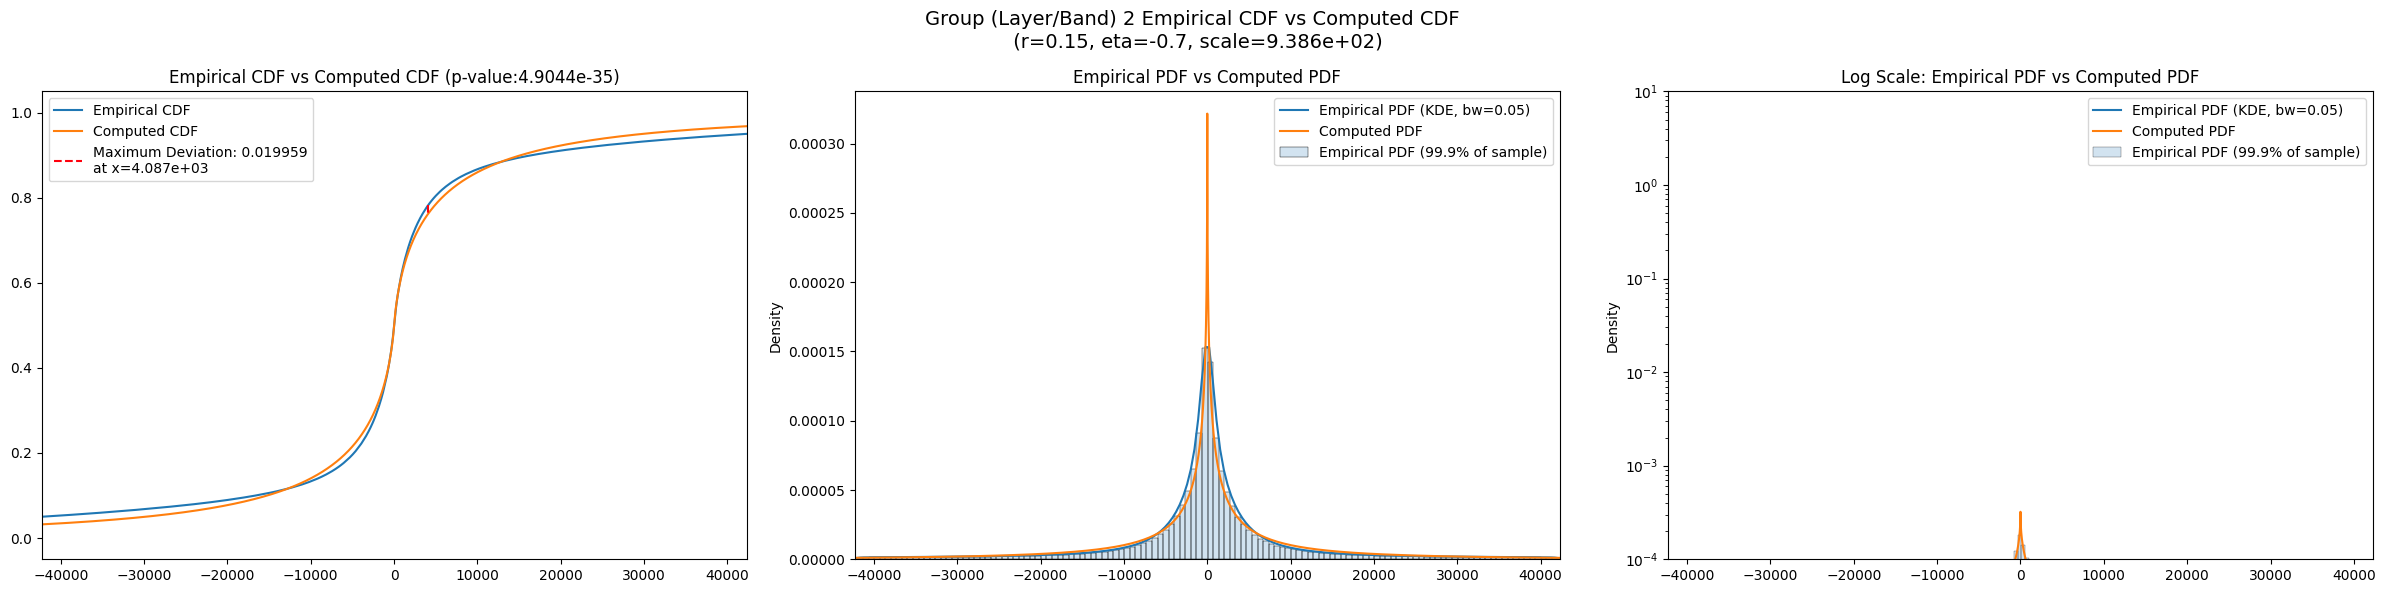

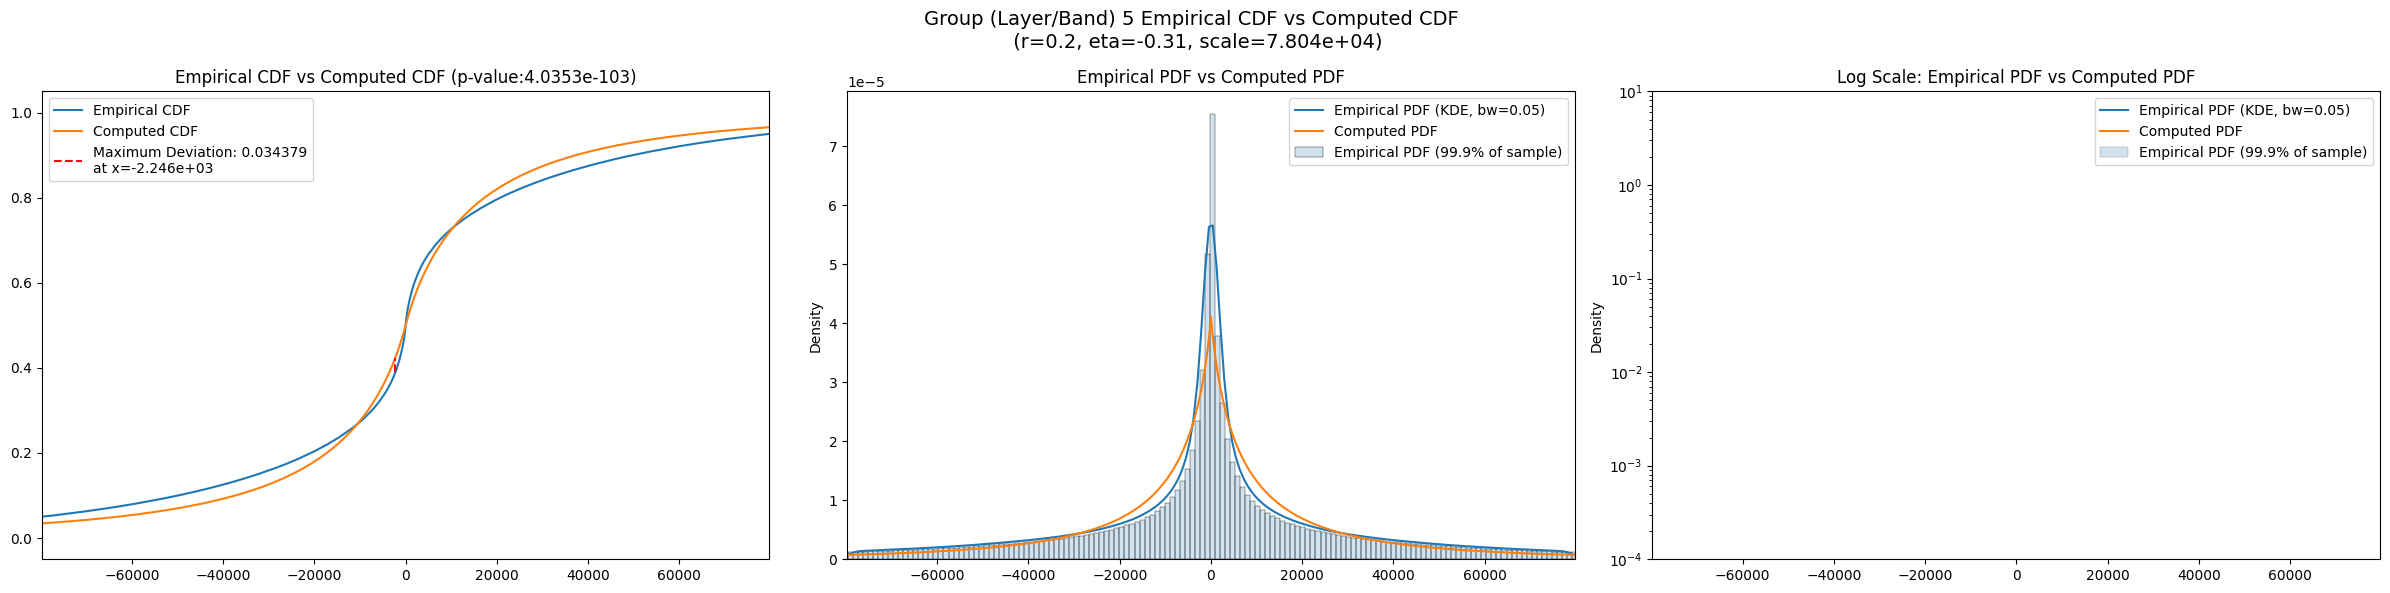

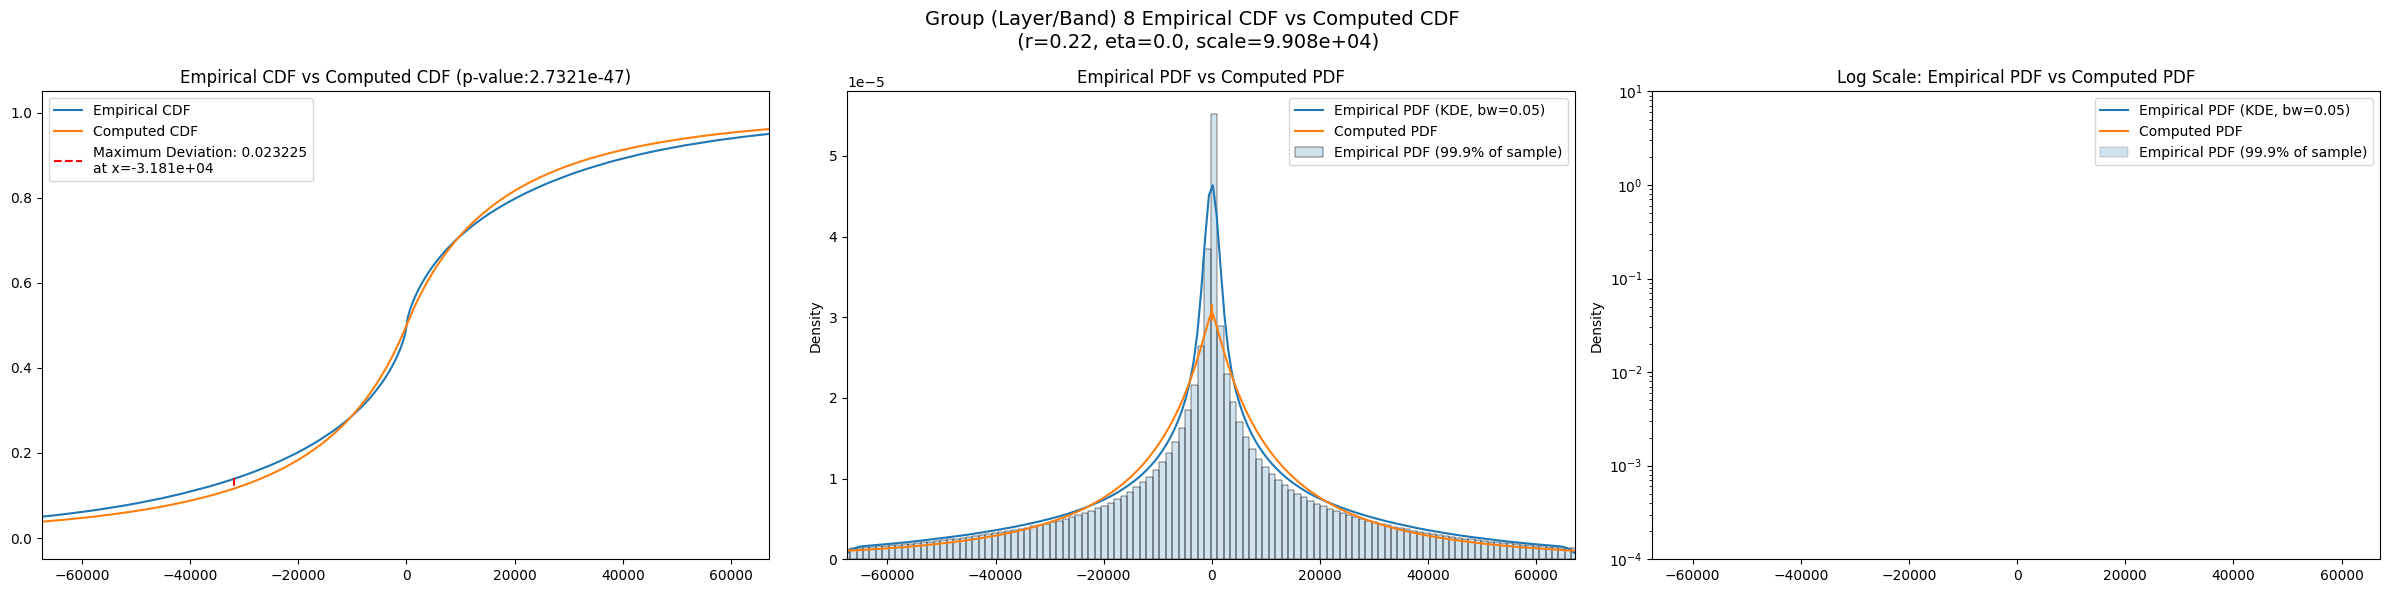

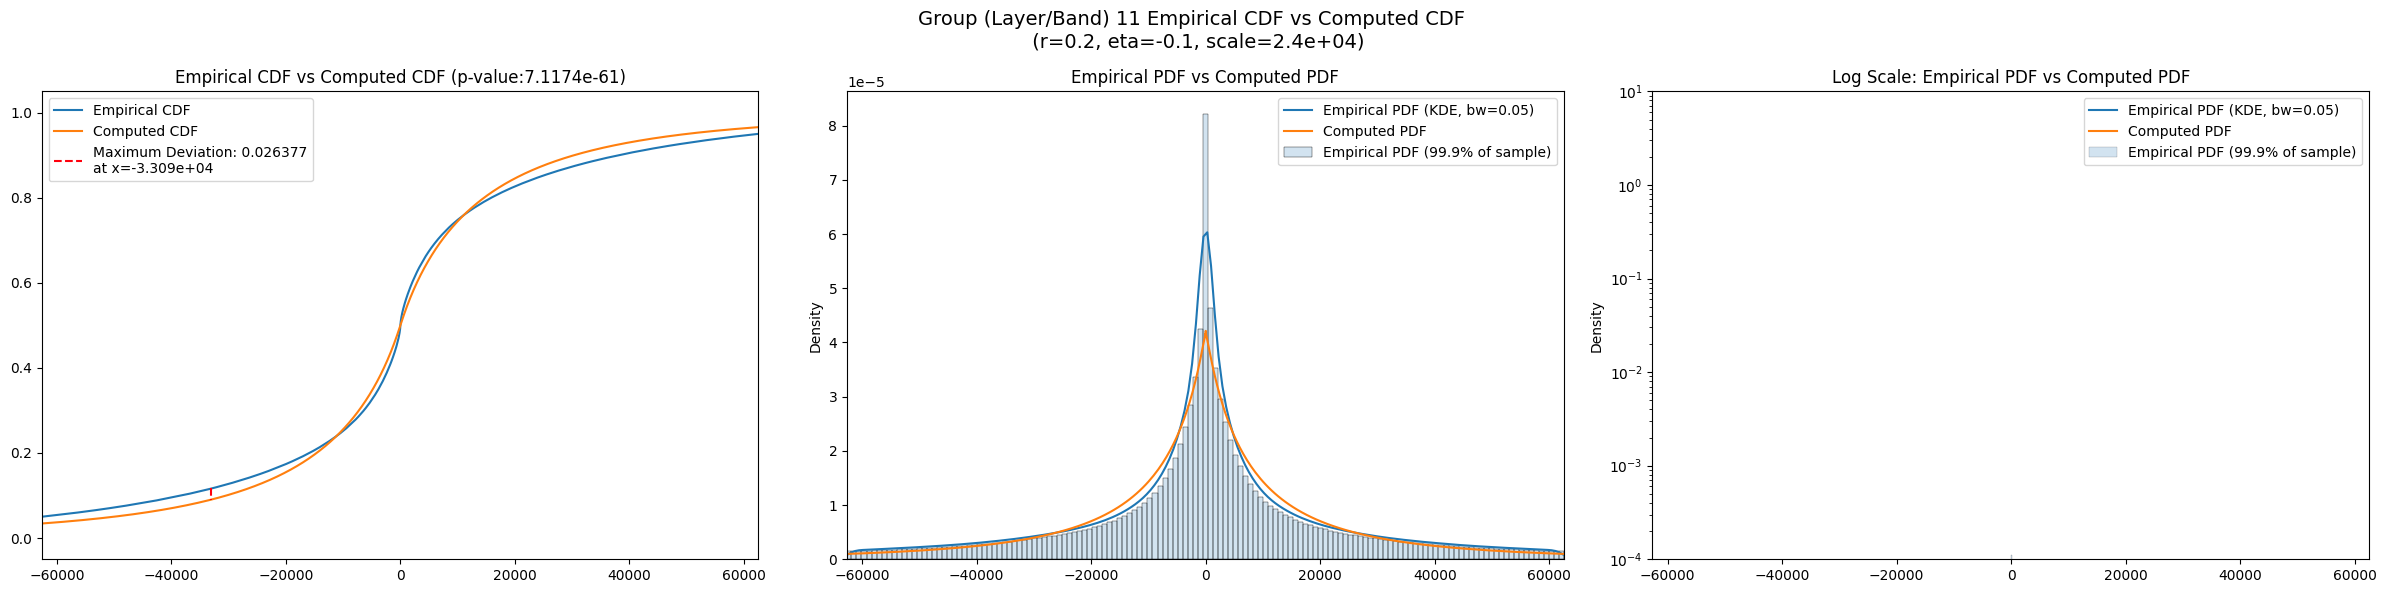

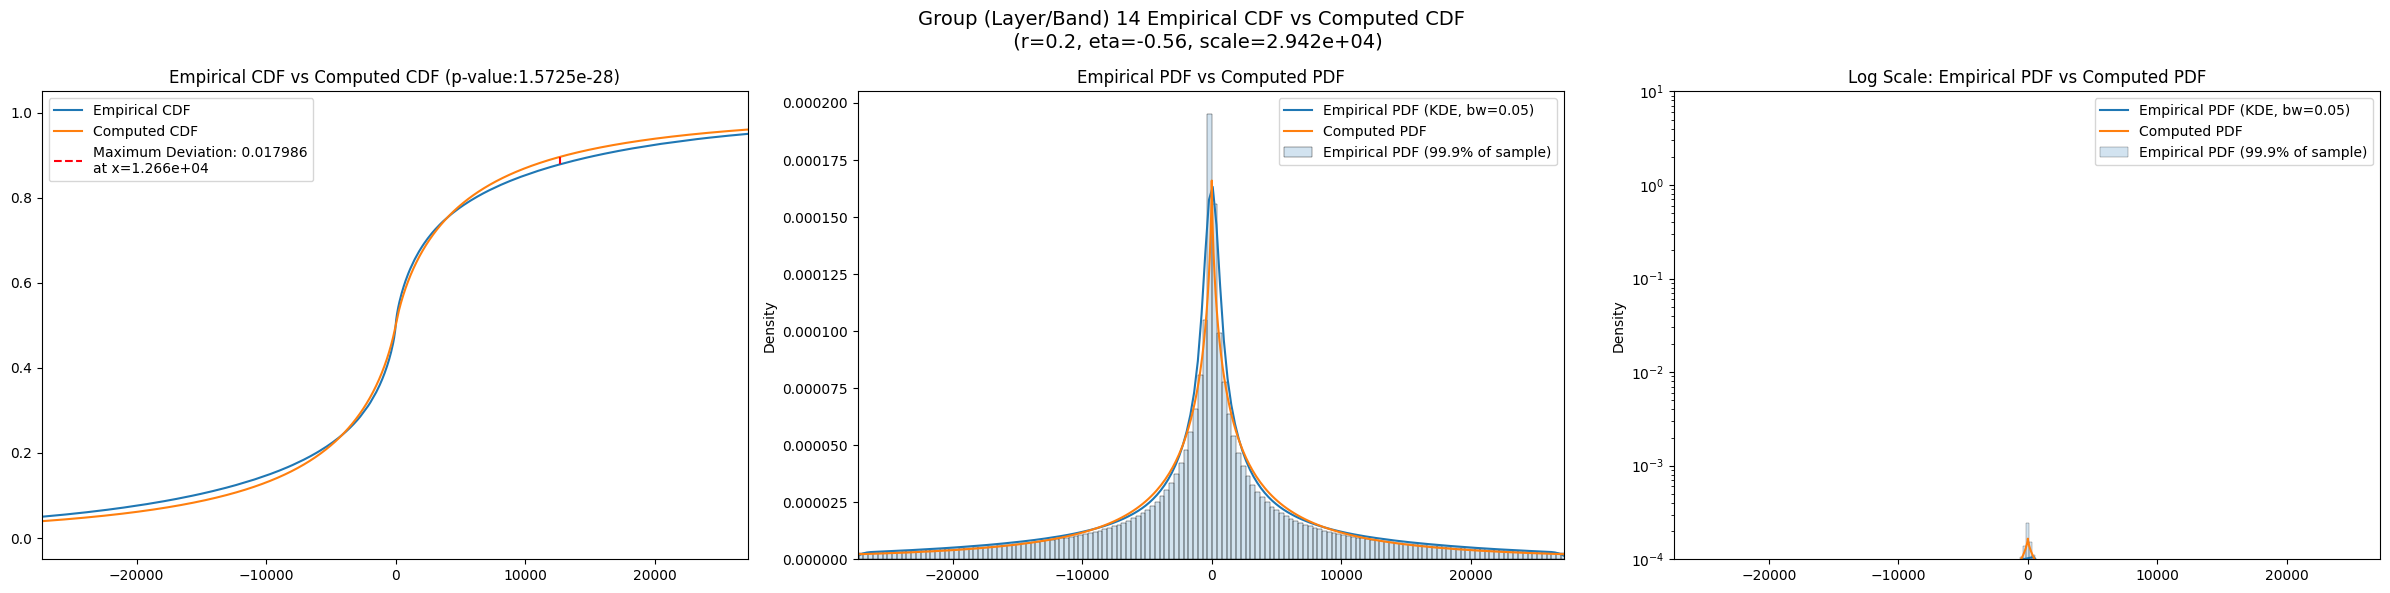

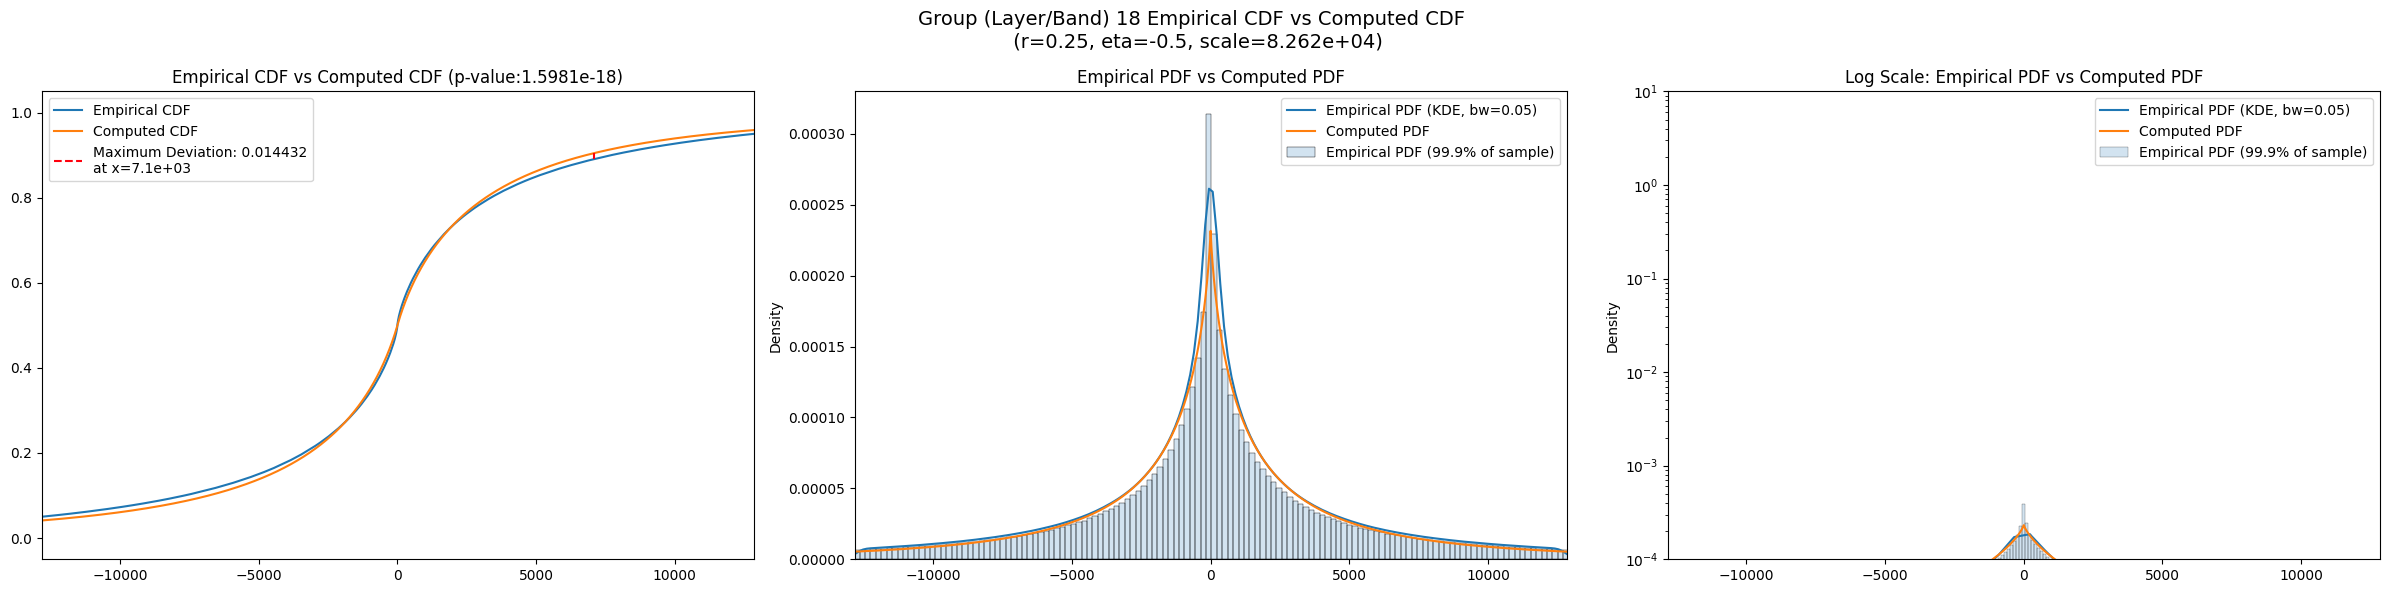

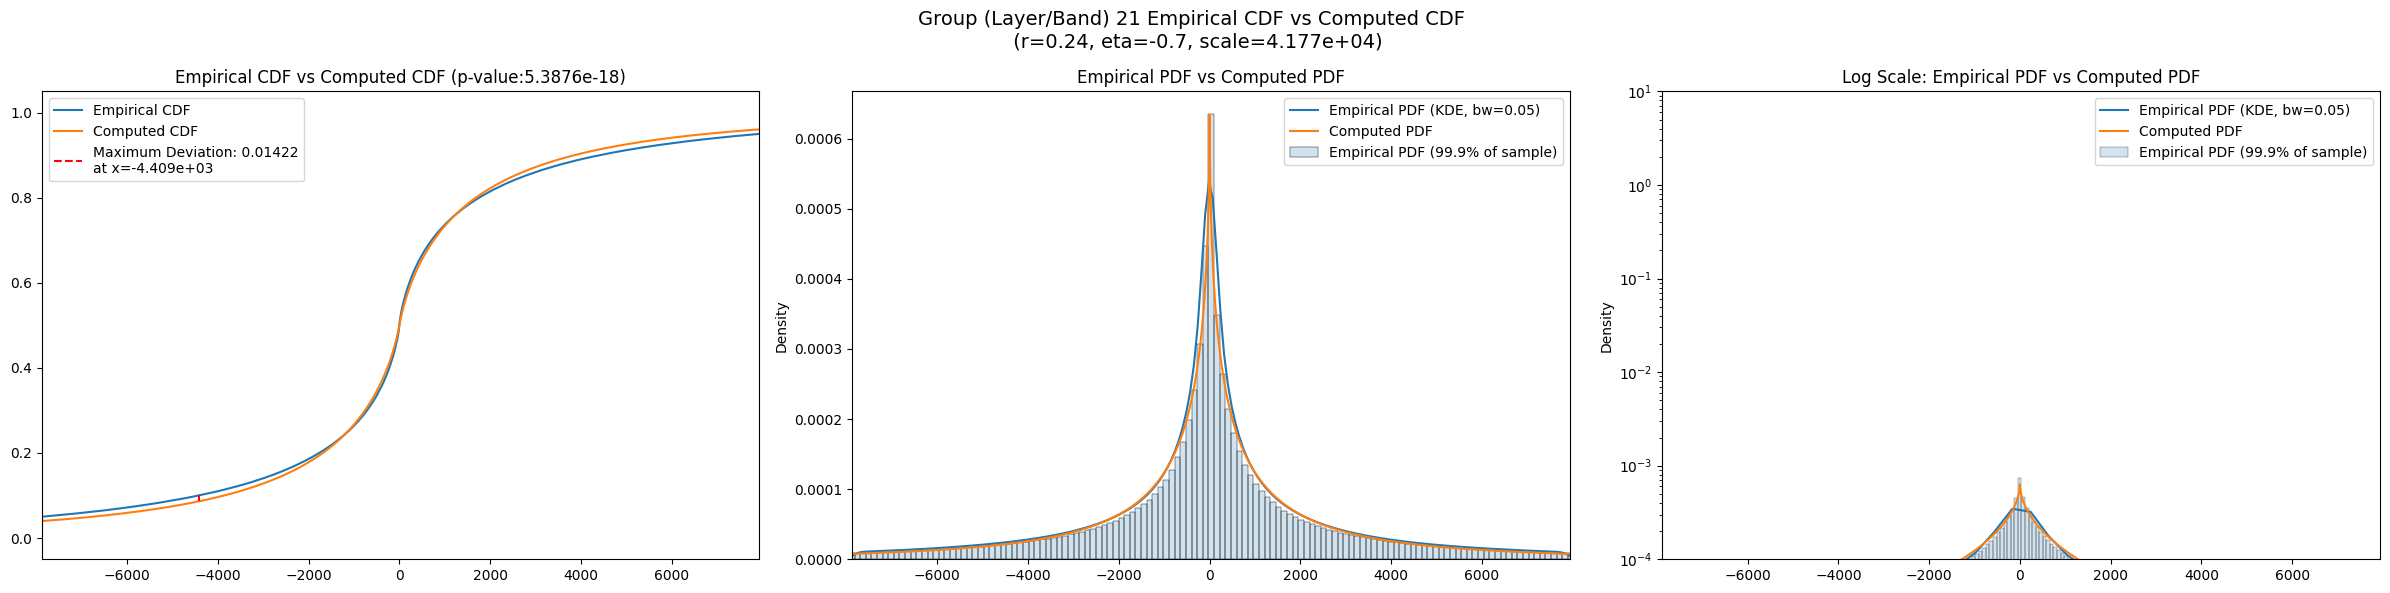

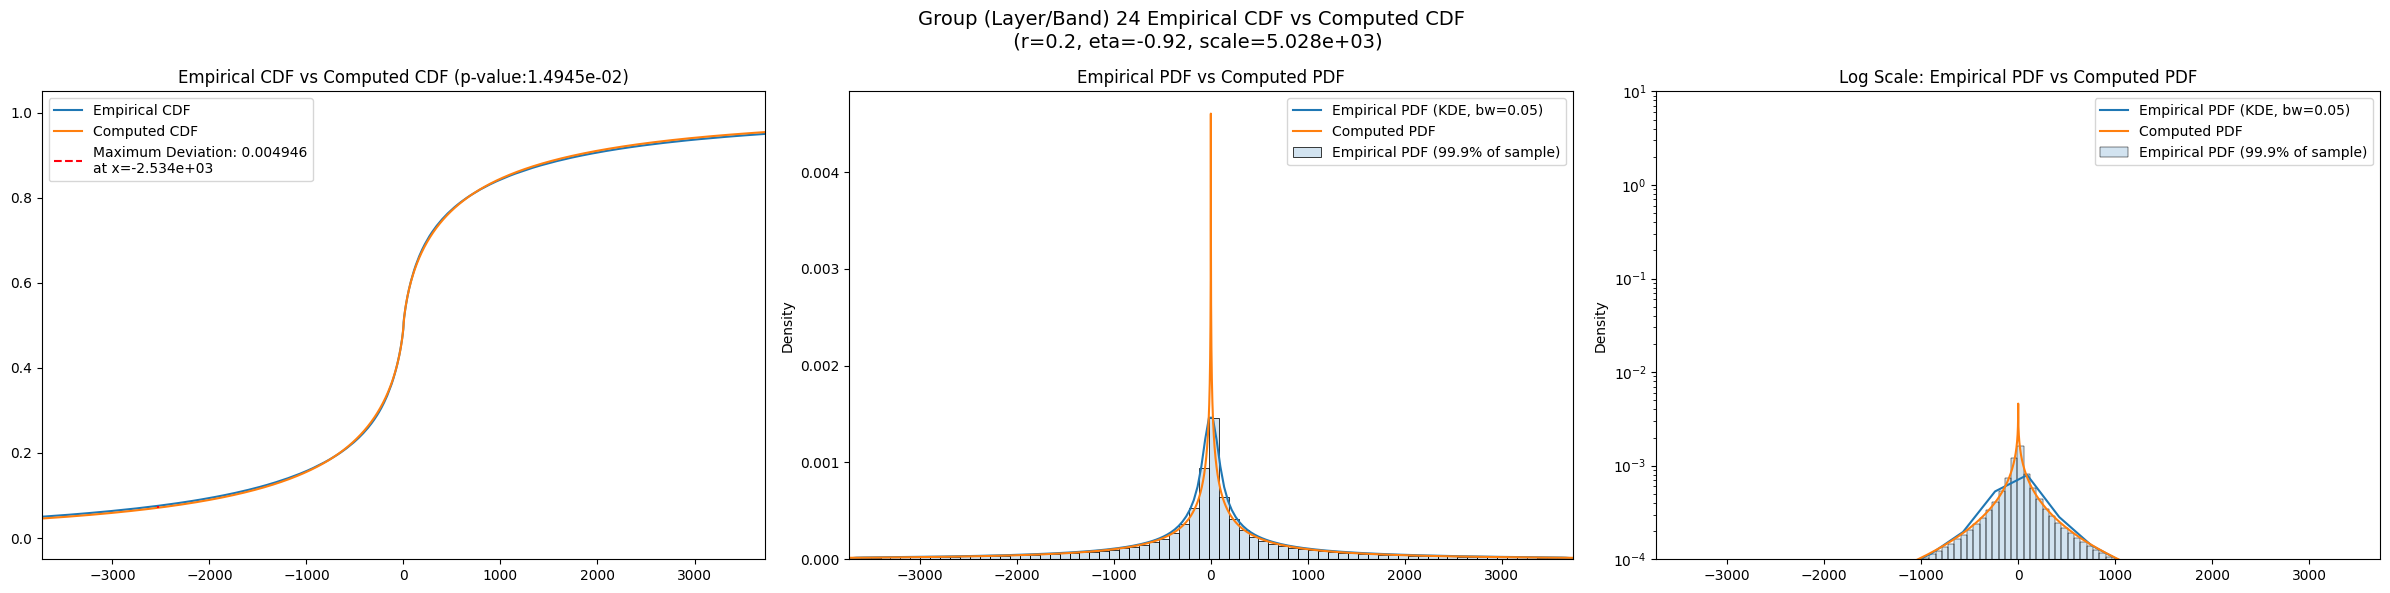

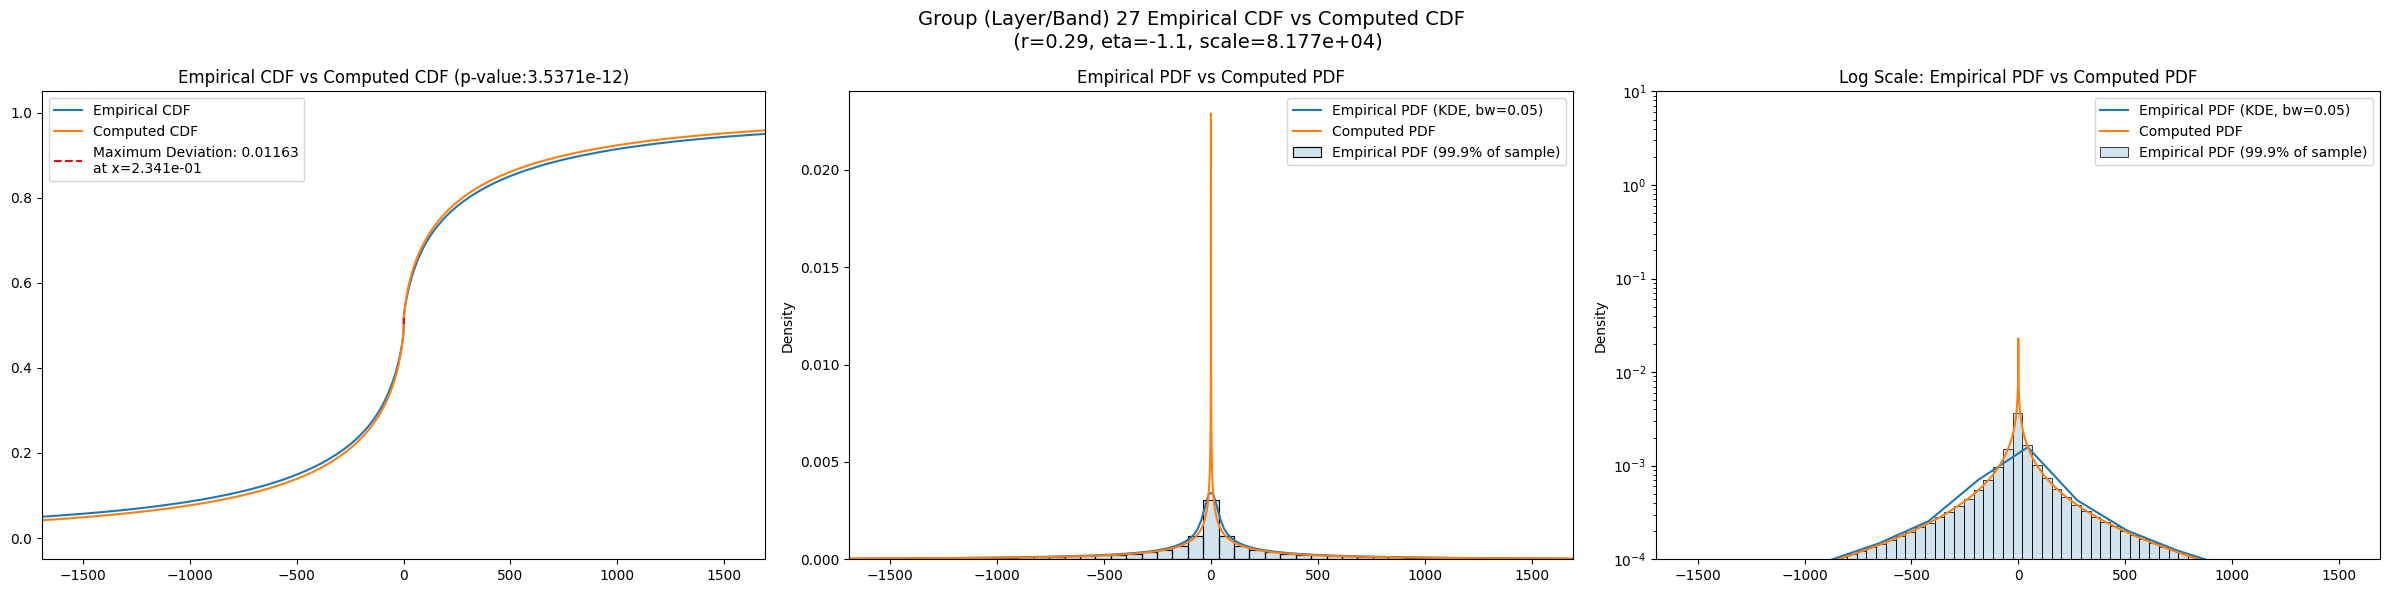

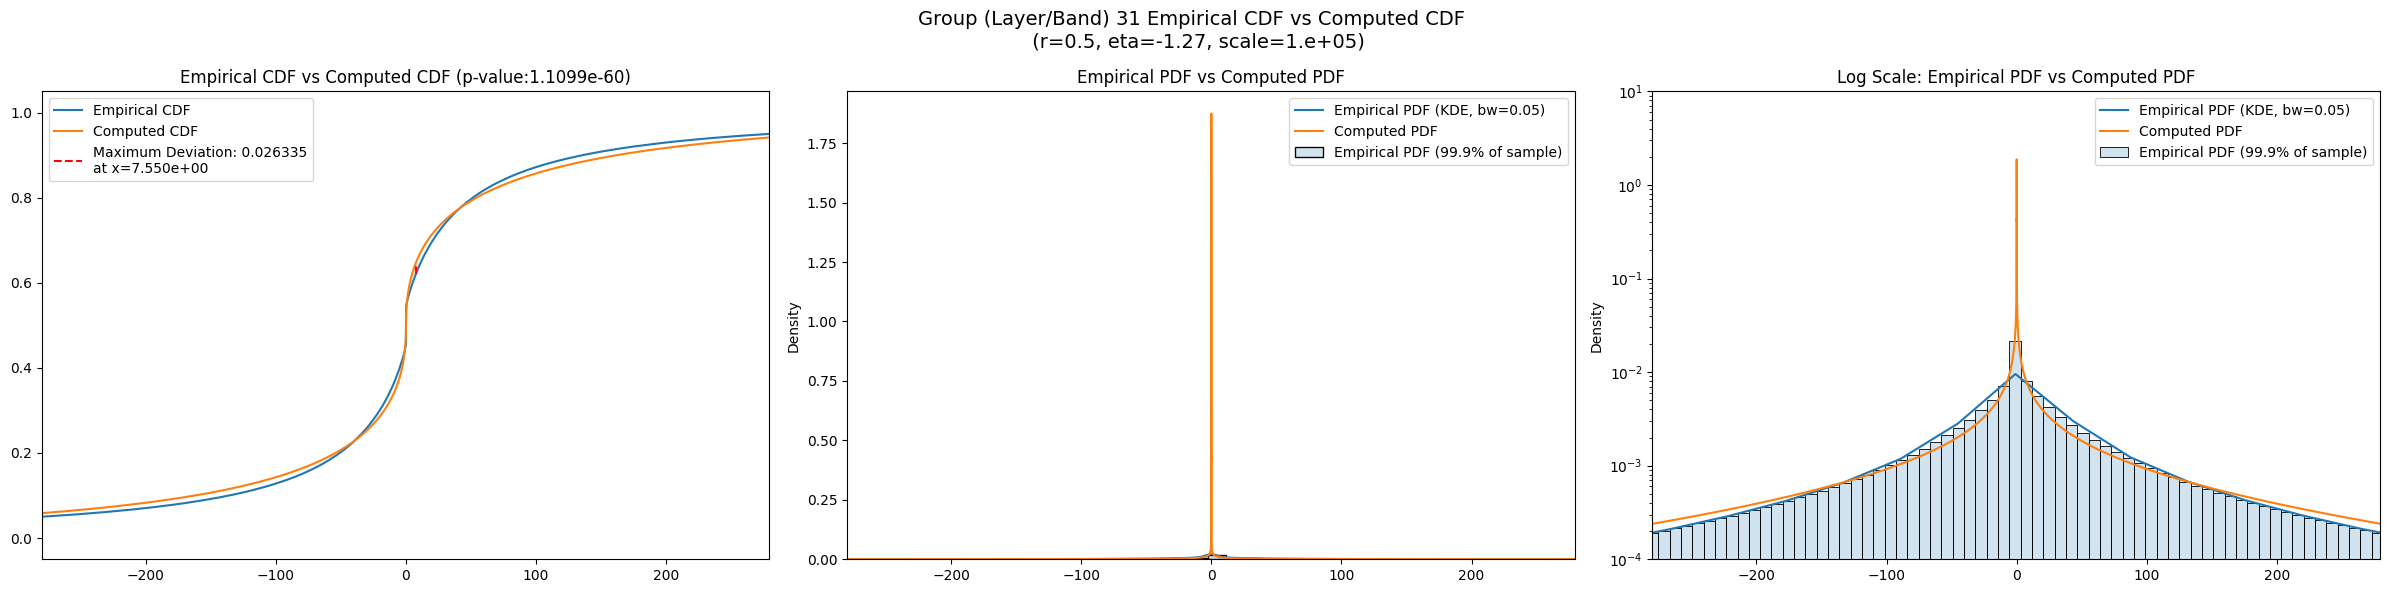

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [19]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336187e+08  8.402026e+08  1.032830e+09   13.948828   11.880425   
5     2.284851e+09  2.136287e+09  2.437953e+09    4.630411    4.061817   
8     1.703496e+09  1.595001e+09  1.815344e+09    4.384782    3.860582   
11    1.330439e+09  1.249094e+09  1.413363e+09    3.781705    3.406619   
14    3.536996e+08  3.235534e+08  3.850865e+08    9.487680    8.329473   
18    6.939949e+07  6.354010e+07  7.573060e+07    9.622860    7.358908   
21    2.943888e+07  2.653933e+07  3.262196e+07   13.824453   10.147264   
24    1.134324e+07  9.638629e+06  1.330031e+07   37.196182   26.251995   
27    4.075887e+06  3.260587e+06  5.040078e+06   69.577060   46.294106   
31    1.346257e+05  1.010121e+05  1.880231e+05  146.759080   58.790752   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.469755     58035773.0             0.021499        0.1         -0.2   
5       5.246209     58035773.0             0.034539        0.2         -0.3   
8       4.929640     58035773.0             0.023857        0.2          0.1   
11      4.176624     58035773.0             0.026377        0.2         -0.1   
14     10.714776     58035773.0             0.020426        0.2         -0.6   
18     12.719344     58035773.0             0.017086        0.2         -0.2   
21     19.833940     58035773.0             0.016624        0.2         -0.5   
24     51.220974     58035773.0             0.006724        0.2         -0.9   
27     98.474080     58035773.0             0.012245        0.3         -1.1   
31    427.171420     58035773.0             0.033321        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       7136.8400              0.090366                   0.0   
5     ...      23634.4000              0.083862                   0.0   
8     ...      24374.8000              0.062257                   0.0   
11    ...      19651.2000              0.074647                   0.0   
14    ...       7617.5800              0.080163                   0.0   
18    ...       4275.3600              0.066589                   0.0   
21    ...       2230.8700              0.076962                   0.0   
24    ...        839.4010              0.087231                   0.0   
27    ...        382.8820              0.086692                   0.0   
31    ...         65.3298              0.081845                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         6477.4900             0.067871                  0.0   4850.2400   
5        19923.4000             0.059979                  0.0  15780.1000   
8        20753.3000             0.037313                  0.0  16691.3000   
11       16906.6000             0.048606                  0.0  13351.1000   
14        6540.5800             0.054714                  0.0   5114.1800   
18        3685.3900             0.040571                  0.0   2897.8500   
21        1925.8500             0.051520                  0.0   1496.2000   
24         728.2930             0.062444                  0.0    557.5410   
27         329.3090             0.062387                  0.0    251.9060   
31          55.4585             0.059197                  0.0     41.8211   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.062971            0.0                   0.0  
5          0.063139            0.0                   0.0  
8          0.041560            0.0                   0.0  
11         0.050891            0.0                   0.0  
14   

## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [21]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.021499                 0.000178          0.019959   
5                0.034539                 0.000178          0.034379   
8                0.023857                 0.000178          0.023225   
11               0.026377                 0.000178          0.026377   
14               0.020426                 0.000178          0.017986   
18               0.017086                 0.000178          0.014432   
21               0.016624                 0.000178          0.014220   
24               0.006724                 0.000178          0.004946   
27               0.012245                 0.000178          0.011618   
31               0.033321                 0.000178          0.026335   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.090366             0.067871       0.062971  
5                 0.083862             0.059979       0.063139  
8                 0.062257             0.037313       0.041560  
11                0.074647             0.048606       0.050891  
14                0.080163             0.054714       0.056368  
18                0.066589             0.040571       0.042650  
21                0.076962             0.051520       0.052511  
24                0.087231             0.062444       0.062038  
27                0.086692             0.062387       0.062635  
31                0.081845             0.059197       0.059804

In [22]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           9.336187e+08          0.019959    0.15     -0.70     938.580825   
5           2.284851e+09          0.034379    0.20     -0.31   78044.599874   
8           1.656895e+09          0.023225    0.22      0.00   99081.876640   
11          1.330439e+09          0.026377    0.20     -0.10   23997.820491   
14          3.536996e+08          0.017986    0.20     -0.56   29415.558206   
18          6.939949e+07          0.014432    0.25     -0.50   82618.438095   
21          2.813458e+07          0.014220    0.24     -0.70   41770.021793   
24          1.134324e+07          0.004946    0.20     -0.92    5027.792359   
27          1.709176e+06          0.011618    0.29     -1.10   81771.931674   
31          7.034058e+04          0.026335    0.50     -1.27  100000.000000   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                    50.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                   25.0  
24                    0.0  
27                  425.0  
31                  175.0